caQTLs were initially called on merged peaks, filtered for 5 reads x sample on average--- however this filter did not removed peaks that did not belong in a celltypes so I will now only use peaks that were called in the cell type. 

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(rasqualTools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(data.table))

In [2]:
# q1 : real lead Q-value vector for all peaks from RASQUAL
# q0 : permutated Q-value vector
# alpha : FDR threshold
# This function returns the P-value threshold corresponding to FDR=alpha.
getFDR <-
function(q1, q0, alpha=0.1, z=NULL, subset=NULL){
	if(is.null(z)){
		a=0
		for(itr in 1:10){
			a=getFDR(q1,q0,alpha,rev(a+0:100/100^itr),subset)
		}
		a
	}else{
		if(!is.null(subset)){
			q1=q1[subset]
			q0=q0[subset]
		}
		q1=q1[!is.na(q1)]
		q0=q0[!is.na(q0)]
		x=NULL;
		for(i in z){
			x=c(x,sum(q0<i)/length(q0)/(sum(q1<i)/length(q1)))
		};
		max(c(0,z[x<alpha]),na.rm=T)
	}
}

In [3]:
maindir     = '/path/to/caQTL/stuff/caQTLs_rasqual/'
setwd(maindir)

In [4]:
celltypes =  c('acinar','alpha','beta','delta','ductal','endothelial','gamma',
                'immune','stellate','bulk')
celltypes_no_bulk = c('acinar','alpha','beta','delta','ductal','endothelial','gamma',
                'immune','stellate')

Load in peaks

In [5]:
inter <- celltypes_no_bulk %>% 
    purrr::map_dfr(\(x) cbind(
        read.table(paste0("/path/to/peaks/recluster_final_majorCTs_v2/",x,".merged_peaks.anno.mergedOverlap.bed")),
        read.table(paste0("/path/to/peaks/recluster_final_majorCTs_v2/",x,".merged_peaks.anno.bed"), col.names=c("V4","V5","V6","V7"))))

inter <- arrange(inter, V1, V2)

inter$Peak = paste0(inter[,1], ':',inter[,2],'-' ,inter[,3])

head(inter, n=20)
dim(inter)

V1   V2     V3     V4   V5     V6     V7          Peak              
1  chr1   9912  10689 chr1   9912  10612 acinar      chr1:9912-10689   
2  chr1   9912  10689 chr1   9913  10658 alpha       chr1:9912-10689   
3  chr1   9912  10689 chr1   9913  10663 beta        chr1:9912-10689   
4  chr1   9912  10689 chr1   9913  10689 delta       chr1:9912-10689   
5  chr1   9912  10689 chr1   9913  10643 ductal      chr1:9912-10689   
6  chr1   9912  10689 chr1   9931  10550 endothelial chr1:9912-10689   
7  chr1   9912  10689 chr1   9919  10684 gamma       chr1:9912-10689   
8  chr1   9912  10689 chr1   9937  10636 immune      chr1:9912-10689   
9  chr1   9912  10689 chr1   9942  10561 stellate    chr1:9912-10689   
10 chr1  29218  29497 chr1  29218  29482 acinar      chr1:29218-29497  
11 chr1  29218  29497 chr1  29297  29497 endothelial chr1:29218-29497  
12 chr1  99525  99851 chr1  99525  99851 acinar      chr1:99525-99851  
13 chr1 102751 103113 chr1 102751 103113 acinar      chr1:102751-103113
14 chr1 102751 103113 chr1 102844 103085 ductal      chr1:102751-103113
15 chr1 127650 127914 chr1 127650 127914 acinar      chr1:127650-127914
16 chr1 127650 127914 chr1 127657 127913 ductal      chr1:127650-127914
17 chr1 180676 181929 chr1 180682 181929 acinar      chr1:180676-181929
18 chr1 180676 181929 chr1 180738 181813 alpha       chr1:180676-181929
19 chr1 180676 181929 chr1 180676 181813 beta        chr1:180676-181929
20 chr1 180676 181929 chr1 180714 181888 delta       chr1:180676-181929

[1] 883312      8

In [6]:
length(unique(filter(inter, V7=="beta")$Peak))
head(unique(filter(inter, V7=="beta")$Peak))

[1] 109942

[1] "chr1:9912-10689"    "chr1:180676-181929" "chr1:190880-191998"
[4] "chr1:267836-268198" "chr1:586024-586331" "chr1:629813-630486"

In [7]:
filter(inter, V7=="beta")$Peak

[1] "chr1:9912-10689"           "chr1:180676-181929"       
    [3] "chr1:190880-191998"        "chr1:267836-268198"       
    [5] "chr1:586024-586331"        "chr1:629813-630486"       
    [7] "chr1:633843-634204"        "chr1:778303-779385"       
    [9] "chr1:794942-795200"        "chr1:804417-805528"       
   [11] "chr1:818694-819260"        "chr1:826727-827888"       
   [13] "chr1:831391-832974"        "chr1:831391-832974"       
   [15] "chr1:842771-843364"        "chr1:851412-852440"       
   [17] "chr1:858017-859141"        "chr1:869555-870297"       
   [19] "chr1:876083-878820"        "chr1:876083-878820"       
   [21] "chr1:898386-899512"        "chr1:903959-905599"       
   [23] "chr1:909933-911705"        "chr1:921046-921418"       
   [25] "chr1:923539-925866"        "chr1:938126-938759"       
   [27] "chr1:939992-941309"        "chr1:941437-942805"       
   [29] "chr1:943145-943498"        "chr1:944380-945038"       
   [31] "chr1:958949-961400"        "chr1:958949-961400"       
   [33] "chr1:965989-967371"        "chr1:975609-976763"       
   [35] "chr1:983850-984659"        "chr1:998647-1001287"      
   [37] "chr1:998647-1001287"       "chr1:1001625-1002151"     
   [39] "chr1:1006272-1007078"      "chr1:1012898-1014577"     
   [41] "chr1:1019116-1021395"      "chr1:1032430-1034294"     
   [43] "chr1:1040074-1041631"      "chr1:1058852-1060009"     
   [45] "chr1:1063691-1064731"      "chr1:1068542-1070511"     
   [47] "chr1:1079331-1080697"      "chr1:1091291-1092259"     
   [49] "chr1:1115741-1117007"      "chr1:1121731-1122829"     
   [51] "chr1:1135461-1135752"      "chr1:1136167-1138117"     
   [53] "chr1:1143670-1145268"      "chr1:1150024-1150744"     
   [55] "chr1:1156781-1158791"      "chr1:1162392-1163849"     
   [57] "chr1:1164536-1165553"      "chr1:1167948-1168269"     
   [59] "chr1:1173394-1174377"      "chr1:1176044-1176756"     
   [61] "chr1:1182611-1183143"      "chr1:1200645-1201880"     
   [63] "chr1:1206458-1206814"      "chr1:1207972-1209037"     
   [65] "chr1:1217847-1218402"      "chr1:1231430-1232763"     
   [67] "chr1:1237537-1238770"      "chr1:1246332-1247589"     
   [69] "chr1:1249888-1250844"      "chr1:1264757-1265373"     
   [71] "chr1:1272270-1274658"      "chr1:1281372-1283263"     
   [73] "chr1:1290193-1290491"      "chr1:1291124-1292410"     
   [75] "chr1:1293342-1294159"      "chr1:1304477-1305185"     
   [77] "chr1:1305397-1305933"      "chr1:1307477-1309722"     
   [79] "chr1:1317900-1318665"      "chr1:1324238-1325815"     
   [81] "chr1:1330659-1331619"      "chr1:1331758-1332195"     
   [83] "chr1:1337431-1338079"      "chr1:1344651-1345159"     
   [85] "chr1:1348609-1350033"      "chr1:1354670-1355907"     
   [87] "chr1:1371909-1372367"      "chr1:1374640-1375880"     
   [89] "chr1:1398782-1400266"      "chr1:1402076-1402438"     
   [91] "chr1:1406474-1408172"      "chr1:1419183-1421837"     
   [93] "chr1:1427253-1427958"      "chr1:1430221-1430982"     
   [95] "chr1:1435317-1436117"      "chr1:1437035-1437434"     
   [97] "chr1:1438045-1438382"      "chr1:1440883-1442450"     
   [99] "chr1:1461789-1463208"      "chr1:1470697-1472391"     
  [101] "chr1:1495377-1496012"      "chr1:1504622-1506063"     
  [103] "chr1:1511029-1512705"      "chr1:1539289-1541256"     
  [105] "chr1:1550791-1552432"      "chr1:1550791-1552432"     
  [107] "chr1:1554508-1555562"      "chr1:1573869-1575547"     
  [109] "chr1:1583512-1584068"      "chr1:1594554-1594822"     
  [111] "chr1:1597081-1598154"      "chr1:1599199-1600696"     
  [113] "chr1:1610082-1610459"      "chr1:1614181-1616767"     
  [115] "chr1:1614181-1616767"      "chr1:1629796-1632495"     
  [117] "chr1:1637291-1637843"      "chr1:1658676-1659582"     
  [119] "chr1:1678224-1679692"      "chr1:1686124-1687259"     
  [121] "chr1:1692278-1693512"      "chr1:1724020-1724861"     
  [123] "chr1:1727335-1727535"      "chr1:1728407-1728828"     
  [125] "chr1:1745631-1746825"      

In [8]:
#maj = inter

In [9]:
#celltypes =  c(   'acinar0', 'acinarREGPOS','alpha_1', "alpha_2",
#                   'beta_1','beta_2','beta_3','beta_4','beta_5','ductal0')
#inter = read.table("../../data/31mergedPeaks_final_both_mergedPeak.intersectAll.bed")
#inter$Peak = paste0(inter[,1], ':',inter[,2],'-' ,inter[,3])
#inter$V7[inter$V7=='ductal']<-'ductal0'
#inter$V7[inter$V7=='acinar']<-'acinar0'

In [10]:
#inter= rbind(maj, inter)

In [11]:
#write.table(inter, "../../data/31mergedPeaks_final_both_mergedPeak.intersectMajAll.bed")

In [12]:
runname <- 'run1'

In [ ]:
getwd()

In [17]:
paste0(c,'/',runname, "/Results_", runname, "_all.tsv")

[1] "alpha/run1/Results_run1_all.tsv"

Filter Rasqual results

In [19]:
#### IN FUTURE SAVE NON LEAD IN PEAK VALUES
df = data.frame()
df_all = data.frame()
for (c in celltypes) {
#for (c in c('alpha')) {
    all = suppressWarnings(fread(paste0(c,'/',runname, "/Results_", runname, "_all.tsv")))
    if (c == 'bulk') {
        real = inter[!duplicated(inter$Peak),]
    } else {
        real = subset(inter, V7 ==c)
    }
    all = subset(all, Feature %in% real$Peak)
    bed = str_split_fixed(all$Feature, ":|-", 3)
    
    mid = as.numeric(bed[,2]) + ((as.numeric(bed[,3])-as.numeric(bed[,2]))/2)
    all$dist = all$position - round(mid)
    
    ### since variants are also outside peaks I order first by distance to center so
    ### if there are ties p-value I choose the closest to the center of the peak
    results       = all[order(abs(all$dist)),]
    results       = results[order(results$P_VAl),]
    results_lead  = results[!duplicated(results$Feature),]
        
    random        = read.table(paste0(c,'/',runname, "/Results_", runname, "_perm1_lead.tsv"), header=T, stringsAsFactors = F)
    random2       = read.table(paste0(c,'/',runname, "/Results_", runname, "_perm2_lead.tsv"), header=T, stringsAsFactors = F)
    random = subset(random, Feature %in% real$Peak)
    random2 = subset(random2, Feature %in% real$Peak)   
        
    thresh10      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.1) 
    thresh05      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.05) 
    thresh01      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.01) 
        
    results$flag_fdr10 = 10^(results$Log10_qval) < thresh10
    results$flag_fdr05 = 10^(results$Log10_qval) < thresh05
    results$flag_fdr01 = 10^(results$Log10_qval) < thresh01
                  
    results_lead$flag_fdr10 = 10^(results_lead$Log10_qval) < thresh10
    results_lead$flag_fdr05 = 10^(results_lead$Log10_qval) < thresh05
    results_lead$flag_fdr01 = 10^(results_lead$Log10_qval) < thresh01
        
    df = rbind(df, c(thresh10, sum(results_lead$flag_fdr10, na.rm=T) , 
                       thresh05, sum(results_lead$flag_fdr05, na.rm=T),
                       thresh01, sum(results_lead$flag_fdr01, na.rm=T), nrow(results_lead)))
    df_all = rbind(df_all, c(thresh10, sum(results$flag_fdr10, na.rm=T) , 
                       thresh05, sum(results$flag_fdr05, na.rm=T),
                       thresh01, sum(results$flag_fdr01, na.rm=T), nrow(results)))
    
    write.table(results_lead, paste0(c,'/',runname, "/Results_", runname, "F_lead.tsv"),sep="\t", quote=F, row.names=F)    
    write.table(results, paste0(c,'/',runname, "/Results_", runname, "F_all.tsv"),sep="\t", quote=F, row.names=F)  
}
rownames(df) = celltypes
colnames(df) = c('qval_fdr10%', 'caQTL_fdr10%', 'qval_fdr05%', 'caQTL_fdr05%','qval_fdr01%', 'caQTL_fdr01%', "tested_features")

rownames(df_all) = celltypes
colnames(df_all) = c('qval_fdr10%', 'caQTL_fdr10%', 'qval_fdr05%', 'caQTL_fdr05%','qval_fdr01%', 'caQTL_fdr01%', "tested_features")

In [27]:
write.csv(df, paste0("summary_",runname,"F.csv"))

In [20]:
df #run1
df_all

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01%
acinar      0.028174635  3050        0.009736167  2144        0.000325682
alpha       0.044057984  5629        0.018495615  4218        0.002634698
beta        0.042475485  7789        0.016592749  5932        0.001646814
delta       0.067561039  1262        0.033722496   877        0.007658465
ductal      0.037689747   419        0.013893899   267        0.001464991
endothelial 0.000000000     0        0.000000000     0        0.000000000
gamma       0.065126695   758        0.034380005   524        0.007940879
immune      0.039476476     9        0.020176438     4        0.020176438
stellate    0.005227418     2        0.005227418     2        0.005227418
bulk        0.041162844 16034        0.016342044 12217        0.001560898
            caQTL_fdr01% tested_features
acinar      1011          96373         
alpha       2546         107935         
beta        3657         106506         
delta        478          79636         
ductal       106          49135         
endothelial    0           1399         
gamma        274          60138         
immune         4           8173         
stellate       2          11915         
bulk        7455         252057

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01%
acinar      0.028174635  84814       0.009736167  57941       0.000325682
alpha       0.044057984 154949       0.018495615 112996       0.002634698
beta        0.042475485 212930       0.016592749 158255       0.001646814
delta       0.067561039  36885       0.033722496  25646       0.007658465
ductal      0.037689747  12856       0.013893899   8491       0.001464991
endothelial 0.000000000      0       0.000000000      0       0.000000000
gamma       0.065126695  23013       0.034380005  15465       0.007940879
immune      0.039476476    244       0.020176438    130       0.020176438
stellate    0.005227418     25       0.005227418     25       0.005227418
bulk        0.041162844 440088       0.016342044 327299       0.001560898
            caQTL_fdr01% tested_features
acinar       25977        4388313       
alpha        66197        4863251       
beta         92020        4797279       
delta        13365        3556559       
ductal        3524        2238072       
endothelial      0          54249       
gamma         7936        2665243       
immune         130         324760       
stellate        25         487126       
bulk        187794       11523909

In [9]:
#df #run7
#df_all 

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01% 
acinar      0.031659935  2383        0.013434835 1721         0.0014642900
alpha       0.029953917  4197        0.010880882 2950         0.0012145723
beta        0.041273722  6412        0.016944413 4814         0.0019907310
delta       0.047913772   925        0.022223624  590         0.0044082471
ductal      0.032362122   302        0.015770048  206         0.0008892251
endothelial 0.000000000     0        0.000000000    0         0.0000000000
gamma       0.050999459   556        0.025606447  357         0.0051055840
immune      0.010118789     2        0.010118789    2         0.0101187891
stellate    0.006784992     2        0.006784992    2         0.0067849918
bulk        0.039079128 12870        0.016153197 9623         0.0018454374
            caQTL_fdr01% tested_features
acinar       889          97477         
alpha       1609         107850         
beta        2825         106428         
delta        285          75797         
ductal        60          42832         
endothelial    0           1578         
gamma        170          62459         
immune         2           7663         
stellate       2          11218         
bulk        5826         251886

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01% 
acinar      0.031659935  65662       0.013434835  46312       0.0014642900
alpha       0.029953917 110973       0.010880882  76672       0.0012145723
beta        0.041273722 172728       0.016944413 126475       0.0019907310
delta       0.047913772  25135       0.022223624  15373       0.0044082471
ductal      0.032362122   8699       0.015770048   5852       0.0008892251
endothelial 0.000000000      0       0.000000000      0       0.0000000000
gamma       0.050999459  16146       0.025606447  10117       0.0051055840
immune      0.010118789     60       0.010118789     60       0.0101187891
stellate    0.006784992     31       0.006784992     31       0.0067849918
bulk        0.039079128 349479       0.016153197 255335       0.0018454374
            caQTL_fdr01% tested_features
acinar       23746        3984750       
alpha        40412        4364120       
beta         72271        4306869       
delta         7400        3075169       
ductal        1852        1762699       
endothelial      0          54624       
gamma         4986        2514222       
immune          60         277833       
stellate        31         418105       
bulk        146642       10348362

In [21]:
#df #2.24.23 Fixed Bulk FDR Calc ******* IN THE FUTURE SAVE THIS run 4

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01% 
acinar      0.03033041   2347        0.01145133  1634         0.0004263997
alpha       0.02874447   4130        0.01343957  3193         0.0011863931
beta        0.04079636   6365        0.01588689  4728         0.0011774070
delta       0.04487330    889        0.01985291   561         0.0035129575
ductal      0.02439943    264        0.01021562   159         0.0047226246
endothelial 0.00000000      0        0.00000000     0         0.0000000000
gamma       0.04766716    528        0.01916613   310         0.0026629268
immune      0.03258025      5        0.02824055     5         0.0282405468
stellate    0.02049126      7        0.01839987     5         0.0183998705
bulk        0.03943915  12890        0.01696841  9747         0.0015364134
            caQTL_fdr01% tested_features
acinar       684          97466         
alpha       1602         107841         
beta        2542         106421         
delta        259          75793         
ductal       118          42828         
endothelial    0           1577         
gamma        134          62455         
immune         5           7660         
stellate       5          11215         
bulk        5599         251868

In [22]:
#dim(results)
#head(results)
#dim(results_lead)
#head(results_lead, n=20)

[1] 10251251       27

Feature                 rsID               Chromosome position Ref Alt Af   
1 chr19:53537305-53539093 chr19:53541015:C:G chr19      53541015 C   G   0.250
2 chr6:32668115-32668714  chr6:32666564:A:G  chr6       32666564 A   G   0.475
3 chr6:32668115-32668714  chr6:32667910:T:C  chr6       32667910 T   C   0.475
4 chr6:32668115-32668714  chr6:32667492:T:C  chr6       32667492 T   C   0.475
5 chr6:32668115-32668714  chr6:32667486:T:C  chr6       32667486 T   C   0.475
6 chr6:32668115-32668714  chr6:32667442:G:A  chr6       32667442 G   A   0.475
  HWEChi_square IA       Log10_qval ⋯ No_tested_SNPs No_iterations_for_H0
1 2.222222      0.972794 -66.74568  ⋯ 151            17                  
2 1.779009      0.999947 -64.35508  ⋯ 312            10                  
3 1.779009      0.999450 -64.35508  ⋯ 312            10                  
4 1.779009      0.999450 -64.35508  ⋯ 312            10                  
5 1.779009      0.999450 -64.35508  ⋯ 312            10                  
6 1.779009      0.999450 -64.35508  ⋯ 312            10                  
  No_iterations_for_H1 ties     Log_likelihood_H0 Convergence_status r2_fSNPs
1  6                   53541015 151.3975          0                  0.889048
2 18                   32666564 145.4551          0                  0.994398
3 18                   32666564 145.4540          0                  0.994398
4 18                   32666564 145.4540          0                  0.994398
5 18                   32666564 145.4540          0                  0.994398
6 18                   32666564 145.4540          0                  0.994398
  r2_rSNP  P_VAl        dist 
1 0.000000 1.189441e-69  2816
2 0.916666 2.120375e-66 -1850
3 0.916588 2.122538e-66  -504
4 0.916588 2.122538e-66  -922
5 0.916588 2.122538e-66  -928
6 0.916588 2.122538e-66  -972

[1] 251868     30

Feature                  rsID               Chromosome position  Ref Alt
1  chr19:53537305-53539093  chr19:53541015:C:G chr19       53541015 C   G  
2  chr6:32668115-32668714   chr6:32666564:A:G  chr6        32666564 A   G  
3  chr20:33105588-33106830  chr20:33105772:G:A chr20       33105772 G   A  
4  chr8:17607871-17609288   chr8:17599351:T:C  chr8        17599351 T   C  
5  chr11:3421659-3423660    chr11:3423208:A:T  chr11        3423208 A   T  
6  chr10:3136160-3137695    chr10:3138567:G:A  chr10        3138567 G   A  
7  chr8:11933329-11935033   chr8:11931528:G:A  chr8        11931528 G   A  
8  chr3:196528489-196529455 chr3:196528863:G:C chr3       196528863 G   C  
9  chr3:125990029-125991054 chr3:125990207:G:T chr3       125990207 G   T  
10 chr6:29680488-29681432   chr6:29680600:T:C  chr6        29680600 T   C  
11 chr3:188351801-188352990 chr3:188352736:G:A chr3       188352736 G   A  
12 chr6:17580142-17581605   chr6:17580458:A:T  chr6        17580458 A   T  
13 chr8:11908856-11909737   chr8:11900257:C:T  chr8        11900257 C   T  
14 chr2:127105661-127107923 chr2:127107345:C:G chr2       127107345 C   G  
15 chr21:44918725-44919329  chr21:44921282:T:C chr21       44921282 T   C  
16 chr13:93454516-93455319  chr13:93459590:A:G chr13       93459590 A   G  
17 chr9:6931452-6932441     chr9:6925663:C:T   chr9         6925663 C   T  
18 chr2:62293165-62294384   chr2:62293802:A:G  chr2        62293802 A   G  
19 chr6:29791742-29793288   chr6:29782999:C:T  chr6        29782999 C   T  
20 chr4:2400836-2402942     chr4:2400580:T:C   chr4         2400580 T   C  
   Af    HWEChi_square IA       Log10_qval ⋯ ties      Log_likelihood_H0
1  0.250 2.222222      0.972794 -66.74568  ⋯  53541015 151.39746        
2  0.475 1.779009      0.999947 -64.35508  ⋯  32666564 145.45507        
3  0.225 0.000257      0.999639 -55.19485  ⋯  33105772 124.36394        
4  0.200 0.078125      0.992906 -50.55234  ⋯  17599351 112.88014        
5  0.100 0.246914      0.973827 -47.79853  ⋯   3422496 105.83540        
6  0.125 0.408163      0.999874 -43.57969  ⋯   3138567  99.04731        
7  0.425 4.772470      0.992984 -44.39306  ⋯  11931528  97.67463        
8  0.325 1.285866      0.982967 -42.70949  ⋯ 196528863  95.90632        
9  0.150 0.622837      0.999311 -41.88744  ⋯ 125990207  91.38309        
10 0.325 1.285866      0.999944 -40.63270  ⋯  29680600  89.92732        
11 0.125 0.408163      0.999422 -40.02292  ⋯ 188352736  87.26147        
12 0.575 0.314101      0.962386 -39.37532  ⋯  17580458  85.85221        
13 0.300 0.045351      0.999938 -36.73276  ⋯  11900257  83.58253        
14 0.175 0.899908      0.998534 -37.24536  ⋯ 127107346  81.43604        
15 0.250 2.222222      0.996647 -36.68052  ⋯  44921282  82.34860        
16 0.275 0.330382      0.999936 -34.06091  ⋯  93459590  77.91448        
17 0.425 2.176987      0.999952 -35.87244  ⋯   6925663  77.39151        
18 0.150 0.622837      0.999894 -35.56012  ⋯  62293802  77.02117        
19 0.100 0.246914      0.999293 -33.59135  ⋯  29782999  76.69058        
20 0.525 1.779009      0.996860 -33.84435  ⋯   2400580  75.57935        
   Convergence_status r2_fSNPs r2_rSNP  P_VAl        dist  flag_fdr10
1  0                  0.889048 0.000000 1.189441e-69  2816 TRUE      
2  0                  0.994398 0.916666 2.120375e-66 -1850 TRUE      
3  0                  0.988165 0.918843 3.304022e-57  -437 TRUE      
4  0                  0.996596 0.820098 1.749427e-52 -9229 TRUE      
5  0                  0.911451 0.959066 1.680679e-49   548 TRUE      
6  0                  0.994053 0.768612 3.387815e-46  1639 TRUE      
7  0                  0.991912 0.889880 1.554083e-45 -2653 TRUE      
8  0                  0.989416 0.970737 3.750977e-45  -109 TRUE      
9  0                  0.994128 0.990250 3.280515e-43  -335 TRUE      
10 0                  0.986177 0.993799 3.447672e-42  -360 TRUE      
11 0                  0.983256 0.989414 2.617820e-41   340 TRUE      
12 0                  0.988646 0.9

In [23]:
#dim(results)
#head(results, n=110)

[1] 10251251       27

Feature                 rsID               Chromosome position Ref Alt
1   chr19:53537305-53539093 chr19:53541015:C:G chr19      53541015 C   G  
2   chr6:32668115-32668714  chr6:32666564:A:G  chr6       32666564 A   G  
3   chr6:32668115-32668714  chr6:32667910:T:C  chr6       32667910 T   C  
4   chr6:32668115-32668714  chr6:32667492:T:C  chr6       32667492 T   C  
5   chr6:32668115-32668714  chr6:32667486:T:C  chr6       32667486 T   C  
6   chr6:32668115-32668714  chr6:32667442:G:A  chr6       32667442 G   A  
7   chr6:32668115-32668714  chr6:32667393:C:T  chr6       32667393 C   T  
8   chr6:32668115-32668714  chr6:32667315:C:A  chr6       32667315 C   A  
9   chr6:32668115-32668714  chr6:32667304:A:G  chr6       32667304 A   G  
10  chr6:32668115-32668714  chr6:32667234:G:A  chr6       32667234 G   A  
11  chr6:32668115-32668714  chr6:32666713:C:T  chr6       32666713 C   T  
12  chr6:32668115-32668714  chr6:32666596:C:T  chr6       32666596 C   T  
13  chr6:32668115-32668714  chr6:32666247:T:A  chr6       32666247 T   A  
14  chr6:32668115-32668714  chr6:32663197:C:T  chr6       32663197 C   T  
15  chr6:32668115-32668714  chr6:32661903:A:G  chr6       32661903 A   G  
16  chr6:32668115-32668714  chr6:32660345:G:C  chr6       32660345 G   C  
17  chr6:32668115-32668714  chr6:32660655:A:G  chr6       32660655 A   G  
18  chr6:32668115-32668714  chr6:32668477:T:C  chr6       32668477 T   C  
19  chr6:32668115-32668714  chr6:32668213:T:C  chr6       32668213 T   C  
20  chr6:32668115-32668714  chr6:32668458:C:T  chr6       32668458 C   T  
21  chr6:32668115-32668714  chr6:32668244:G:A  chr6       32668244 G   A  
22  chr6:32668115-32668714  chr6:32668127:T:A  chr6       32668127 T   A  
23  chr6:32668115-32668714  chr6:32668188:G:T  chr6       32668188 G   T  
24  chr6:32668115-32668714  chr6:32668413:G:A  chr6       32668413 G   A  
25  chr6:32668115-32668714  chr6:32658242:C:T  chr6       32658242 C   T  
26  chr6:32668115-32668714  chr6:32658238:C:A  chr6       32658238 C   A  
27  chr20:33105588-33106830 chr20:33105772:G:A chr20      33105772 G   A  
28  chr20:33105588-33106830 chr20:33102548:G:A chr20      33102548 G   A  
29  chr20:33105588-33106830 chr20:33107159:G:A chr20      33107159 G   A  
30  chr20:33105588-33106830 chr20:33107169:G:A chr20      33107169 G   A  
⋮   ⋮                       ⋮                  ⋮          ⋮        ⋮   ⋮  
81  chr8:17607871-17609288  chr8:17601272:T:C  chr8       17601272 T   C  
82  chr8:17607871-17609288  chr8:17601122:G:C  chr8       17601122 G   C  
83  chr8:17607871-17609288  chr8:17600184:T:G  chr8       17600184 T   G  
84  chr8:17607871-17609288  chr8:17600190:A:G  chr8       17600190 A   G  
85  chr8:17607871-17609288  chr8:17601132:C:A  chr8       17601132 C   A  
86  chr8:17607871-17609288  chr8:17601129:A:G  chr8       17601129 A   G  
87  chr8:17607871-17609288  chr8:17601437:A:G  chr8       17601437 A   G  
88  chr8:17607871-17609288  chr8:17611175:G:C  chr8       17611175 G   C  
89  chr20:33105588-33106830 chr20:33103873:G:A chr20      33103873 G   A  
90  chr20:33105588-33106830 chr20:33097599:C:T chr20      33097599 C   T  
91  chr10:3136160-3137695   chr10:3138567:G:A  chr10       3138567 G   A  
92  chr10:3136160-3137695   chr10:3145866:G:A  chr10       3145866 G   A  
93  chr20:33105588-33106830 chr20:33108733:C:G chr20      33108733 C   G  
94  chr11:3421659-3423660   chr11:3428497:C:A  chr11       3428497 C   A  
95  chr11:3421659-3423660   chr11:3428502:T:G  chr11       3428502 T   G  
96  chr11:3421659-3423660   chr11:3429035:G:A  chr11       3429035 G   A  
97  chr8:17607871-17609288  chr8:17607720:T:C  chr8       17607720 T   C  
98  chr8:17607871-17609288  chr8:17600214:A:T  chr8       17600214 A   T  
99  chr8:17607871-17609288  chr8:17611510:C:A  chr8       17611510 C   A  
100 chr11:3421659-3423660   chr11:3428452:A:C  chr11       3428452 A   C  
101 chr11:3421659-3423660   chr11:3428464:A:G  chr11       3428464 A   G  
102 chr11:3421659-3423660   c

In [9]:
#df #2.17.23

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01% 
acinar      0.03033041  2347         0.01145133  1634         0.0004263997
alpha       0.02874447  4130         0.01343957  3193         0.0011863931
beta        0.04079636  6365         0.01588689  4728         0.0011774070
delta       0.04487330   889         0.01985291   561         0.0035129575
ductal      0.02439943   264         0.01021562   159         0.0047226246
endothelial 0.00000000     0         0.00000000     0         0.0000000000
gamma       0.04766716   528         0.01916613   310         0.0026629268
immune      0.03258025     5         0.02824055     5         0.0282405468
stellate    0.02049126     7         0.01839987     5         0.0183998705
            caQTL_fdr01% tested_features
acinar       684          97466         
alpha       1602         107841         
beta        2542         106421         
delta        259          75793         
ductal       118          42828         
endothelial    0           1577         
gamma        134          62455         
immune         5           7660         
stellate       5          11215

In [20]:
#df

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01% 
acinar      0.03033041  2347         0.01145133  1634         0.0004263997
alpha       0.02874447  4130         0.01343957  3193         0.0011863931
beta        0.04079636  6365         0.01588689  4728         0.0011774070
delta       0.04487330   889         0.01985291   561         0.0035129575
ductal      0.02439943   264         0.01021562   159         0.0047226246
endothelial 0.00000000     0         0.00000000     0         0.0000000000
gamma       0.04766716   528         0.01916613   310         0.0026629268
immune      0.03258025     5         0.02824055     5         0.0282405468
stellate    0.02049126     7         0.01839987     5         0.0183998705
            caQTL_fdr01% tested_features
acinar       684          97466         
alpha       1602         107841         
beta        2542         106421         
delta        259          75793         
ductal       118          42828         
endothelial    0           1577         
gamma        134          62455         
immune         5           7660         
stellate       5          11215

In [51]:
#df

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01% 
acinar 0.03146046  2566         0.01205266  1847         5.484286e-04
alpha  0.03929289  4505         0.01620121  3233         2.048869e-03
delta  0.04689757  1111         0.02081558   720         3.067506e-03
ductal 0.03853054   561         0.01137135   288         1.907976e-03
gamma  0.05328094   635         0.03230032   472         3.919157e-06
beta   0.04646797  7231         0.02001172  5552         2.904411e-03
       caQTL_fdr01% tested_features
acinar  831          97725         
alpha  1797         106194         
delta   308          84110         
ductal  139          56121         
gamma    20          63945         
beta   3441         103378

In [57]:
#df

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01% 
acinar0      0.03337939  2385         0.010293408 1545         9.208149e-04
acinarREGPOS 0.03606478   415         0.016793433  275         2.632380e-03
alpha_1      0.03127896  3714         0.014461874 2821         1.192308e-03
alpha_2      0.04402970   936         0.025016512  692         5.367660e-03
beta_1       0.05448826  5631         0.024369634 4233         2.370170e-03
beta_2       0.06039367  2005         0.030379753 1437         4.610189e-03
beta_3       0.03142963  1225         0.013190222  816         1.564463e-03
beta_4       0.01838352   574         0.006884589  350         4.333309e-05
beta_5       0.02242294   112         0.008932167   63         1.523932e-04
ductal0      0.03428380   453         0.013808598  280         1.686291e-03
             caQTL_fdr01% tested_features
acinar0       780          97623         
acinarREGPOS  125          42212         
alpha_1      1427         106995         
alpha_2       325          76525         
beta_1       2234         107769         
beta_2        667          93583         
beta_3        374          82124         
beta_4         67          71400         
beta_5         10          36245         
ductal0       123          52421

In [21]:
test = read.table(paste0('beta/run1', "/Results_run1F_lead.tsv"), header=T, stringsAsFactors = F)

dim(test)
head(test)

[1] 106506     30

Feature                  rsID               Chromosome position  Ref Alt
1 chr11:3421659-3423660    chr11:3422496:T:A  chr11        3422496 T   A  
2 chr20:33105588-33106830  chr20:33106308:A:G chr20       33106308 A   G  
3 chr6:32668115-32668714   chr6:32666564:A:G  chr6        32666564 A   G  
4 chr3:188351801-188352990 chr3:188352736:G:A chr3       188352736 G   A  
5 chr8:17607871-17609288   chr8:17602712:A:G  chr8        17602712 A   G  
6 chr7:4135654-4136914     chr7:4136257:A:G   chr7         4136257 A   G  
  Af       HWEChi_square IA       Log10_qval ⋯ ties      Log_likelihood_H0
1 0.111111 0.421875      0.961691 -77.18683  ⋯   3422496 173.76734        
2 0.259259 0.034439      0.998589 -57.48574  ⋯  33106308 129.46566        
3 0.388889 5.578512      0.999942 -56.81707  ⋯  32666564 128.61093        
4 0.092593 0.281133      0.999396 -47.98072  ⋯ 188352736 105.87696        
5 0.203704 0.020395      0.999579 -44.90745  ⋯  17602712 102.55801        
6 0.055556 0.093426      0.999376 -39.88028  ⋯   4136257  92.91926        
  Convergence_status r2_fSNPs r2_rSNP  P_VAl        dist  flag_fdr10 flag_fdr05
1 0                  0.818913 0.944782 3.460434e-79  -164 TRUE       TRUE      
2 0                  0.992436 0.993817 3.043698e-59    99 TRUE       TRUE      
3 0                  0.995213 0.856132 7.157935e-59 -1850 TRUE       TRUE      
4 0                  0.987970 0.986822 2.747480e-49   340 TRUE       TRUE      
5 0                  0.993821 0.708275 8.476066e-48 -5868 TRUE       TRUE      
6 0                  0.983770 0.979391 1.221008e-41   -27 TRUE       TRUE      
  flag_fdr01
1 TRUE      
2 TRUE      
3 TRUE      
4 TRUE      
5 TRUE      
6 TRUE

In [22]:
oriq = test$Feature[test$flag_fdr05==T]

this test confirms that it was the same as just filtering the old lead summary -- in fact the p.value thresholds are very very similar

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


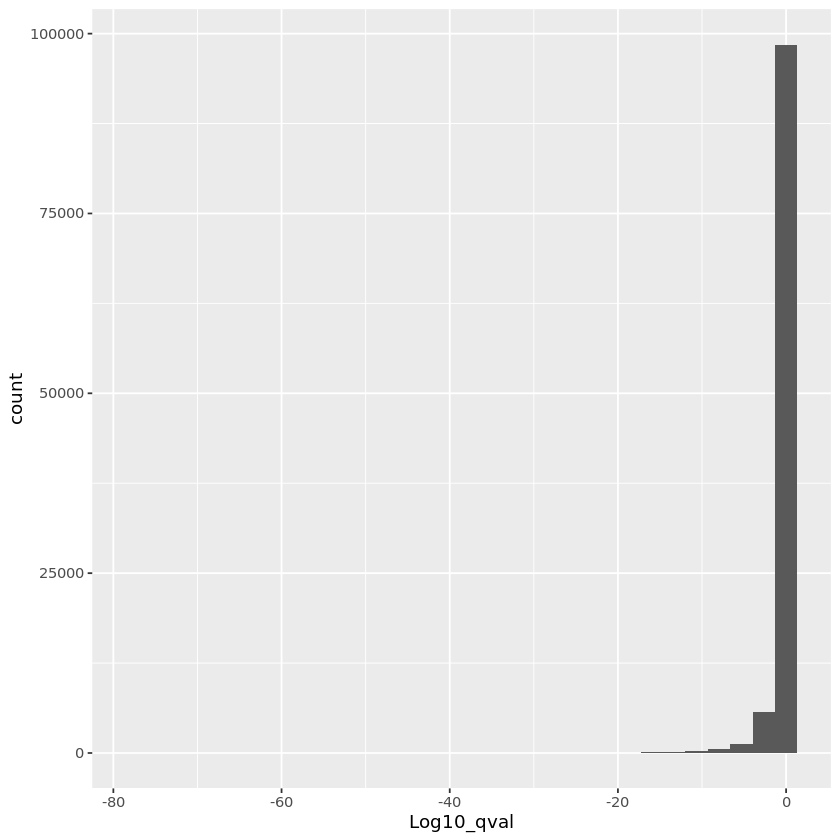

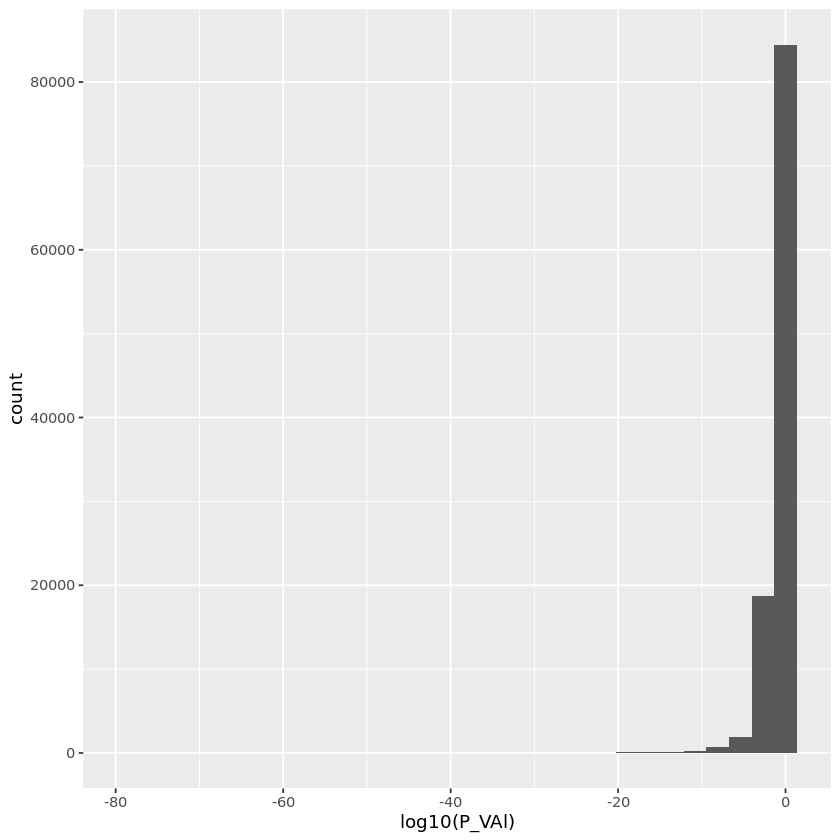

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


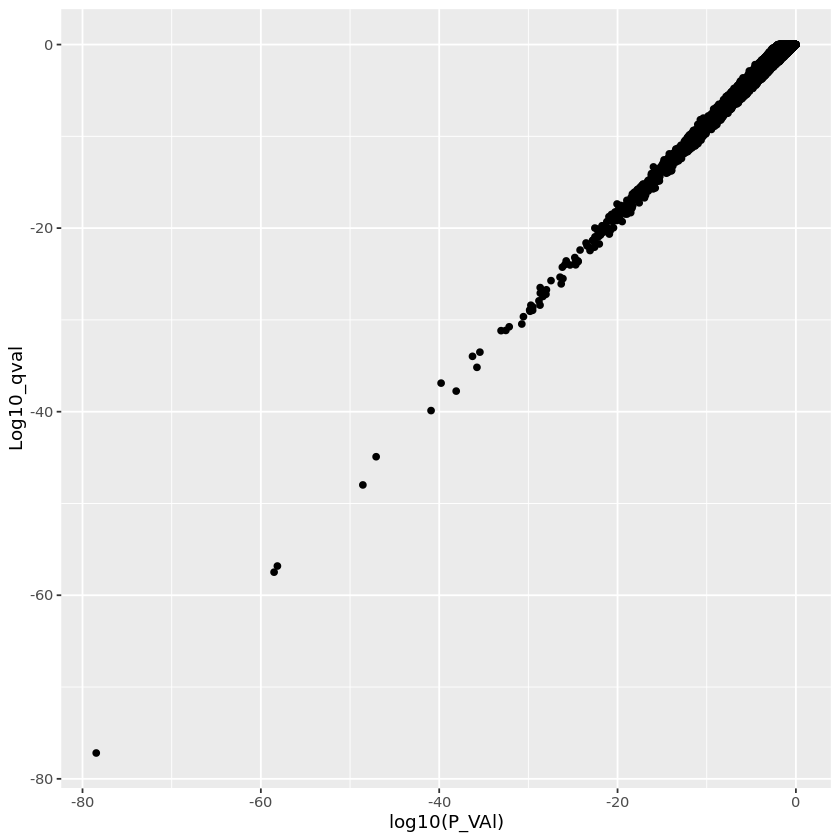

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


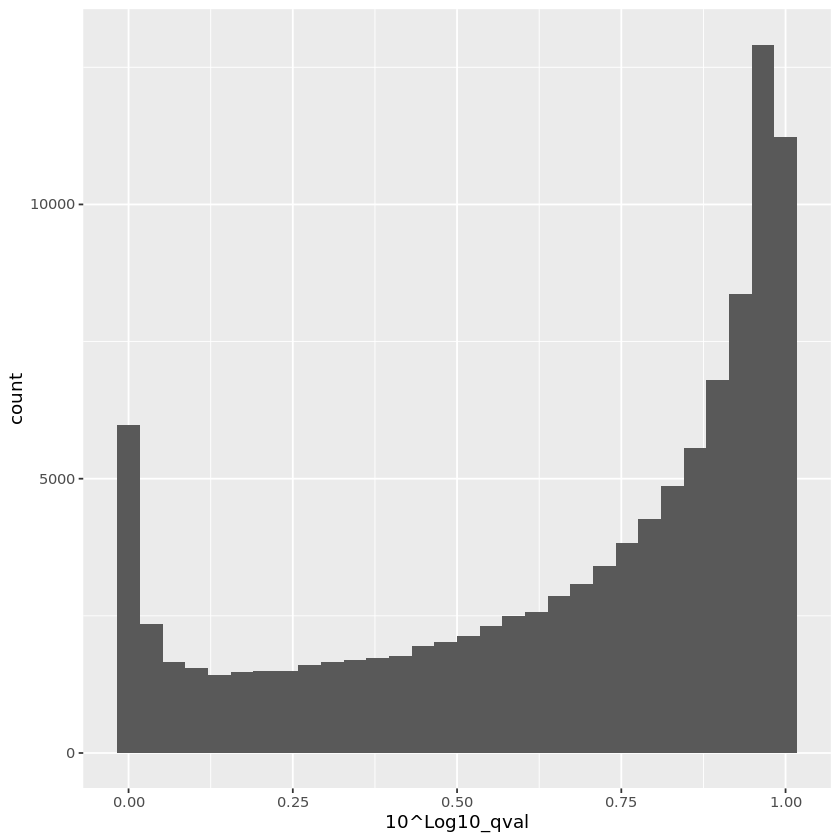

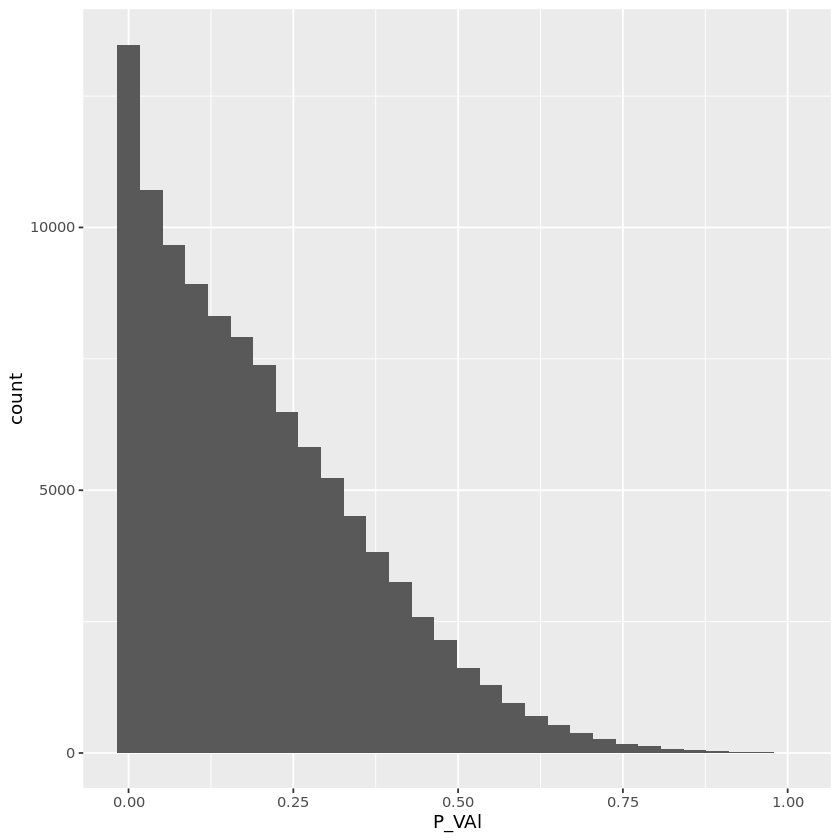

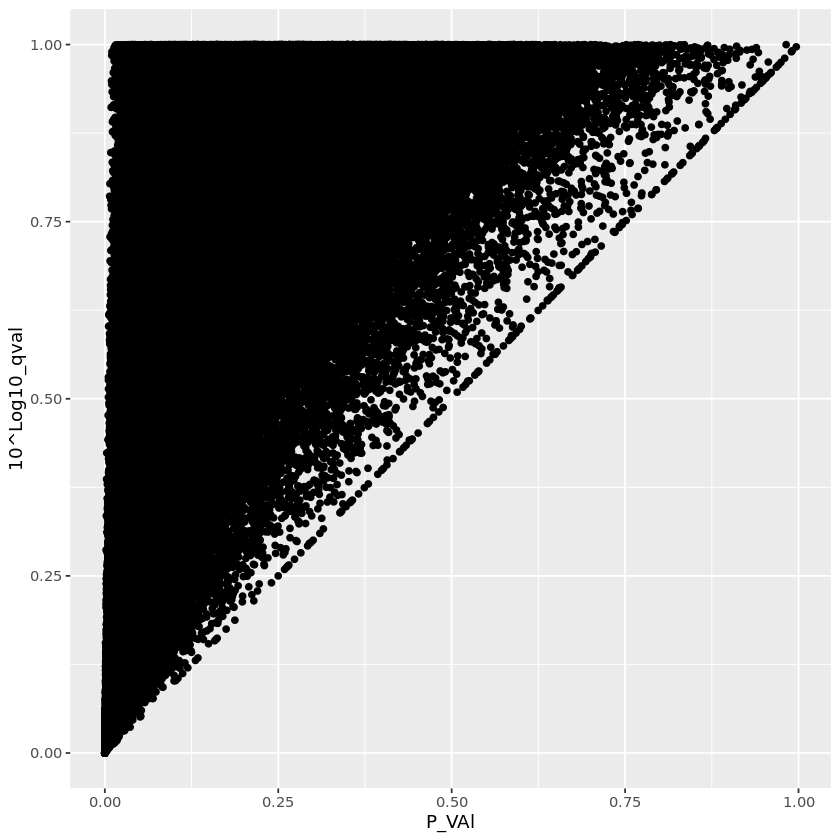

In [24]:
library(ggplot2)

ggplot(test,aes(x=Log10_qval)) + geom_histogram()
ggplot(test,aes(x=log10(P_VAl))) + geom_histogram()

ggplot(test, aes(x=log10(P_VAl), y=Log10_qval)) + geom_point()


ggplot(test,aes(x=10^Log10_qval)) + geom_histogram()
ggplot(test,aes(x=P_VAl)) + geom_histogram()

ggplot(test, aes(x=P_VAl, y=10^Log10_qval)) + geom_point()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


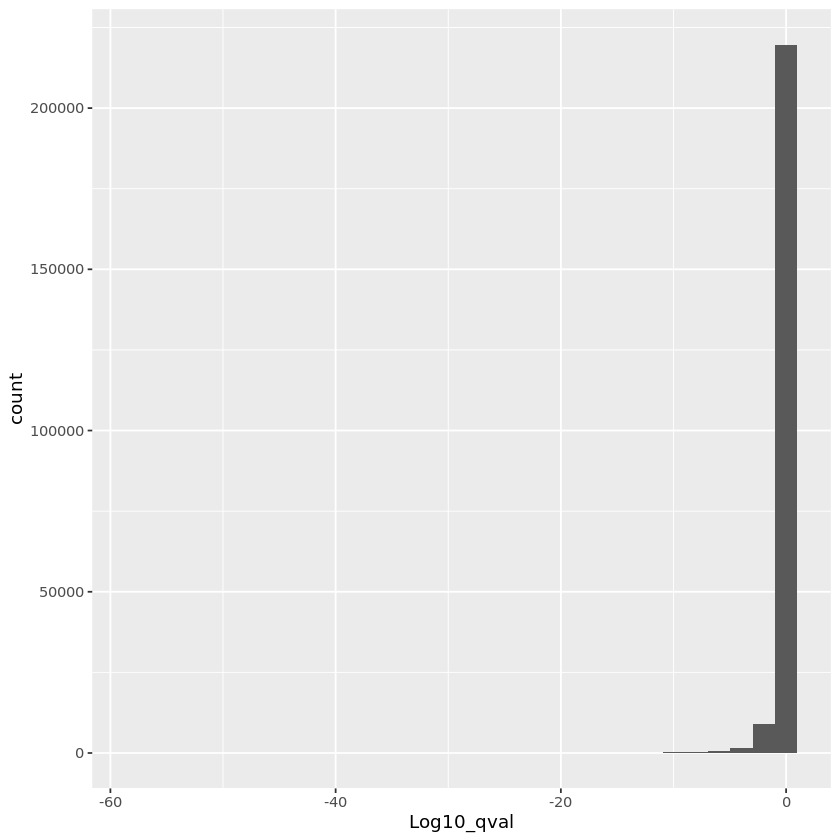

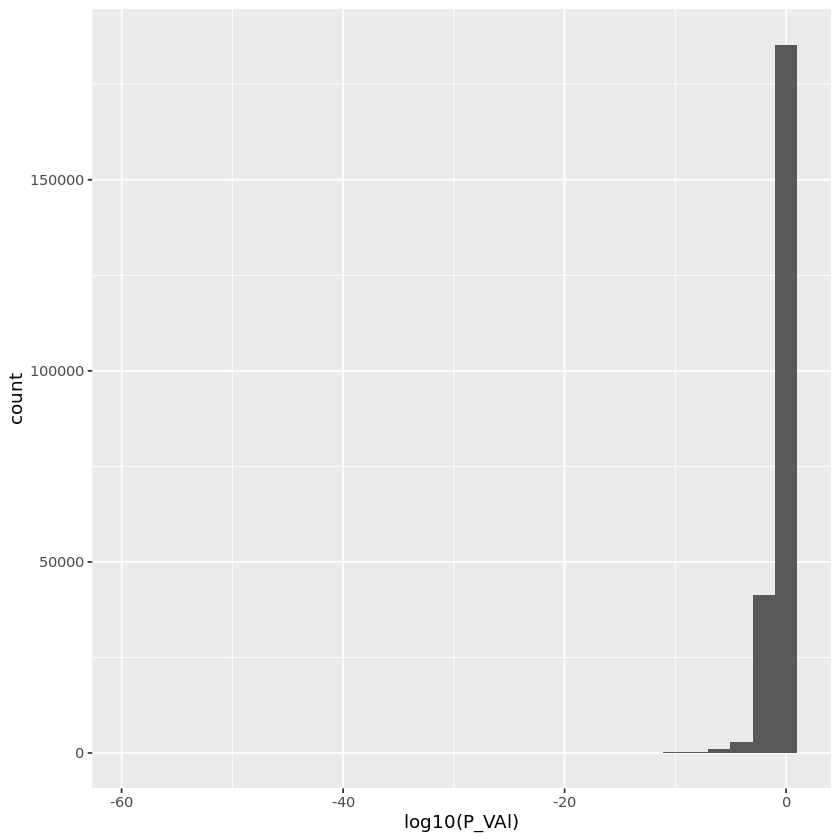

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


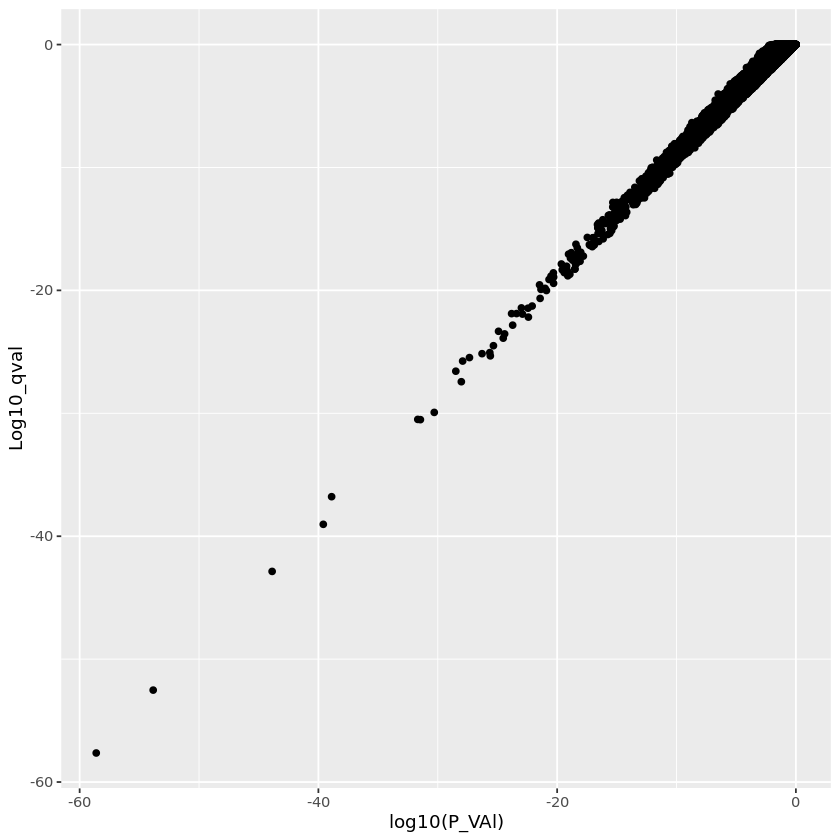

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


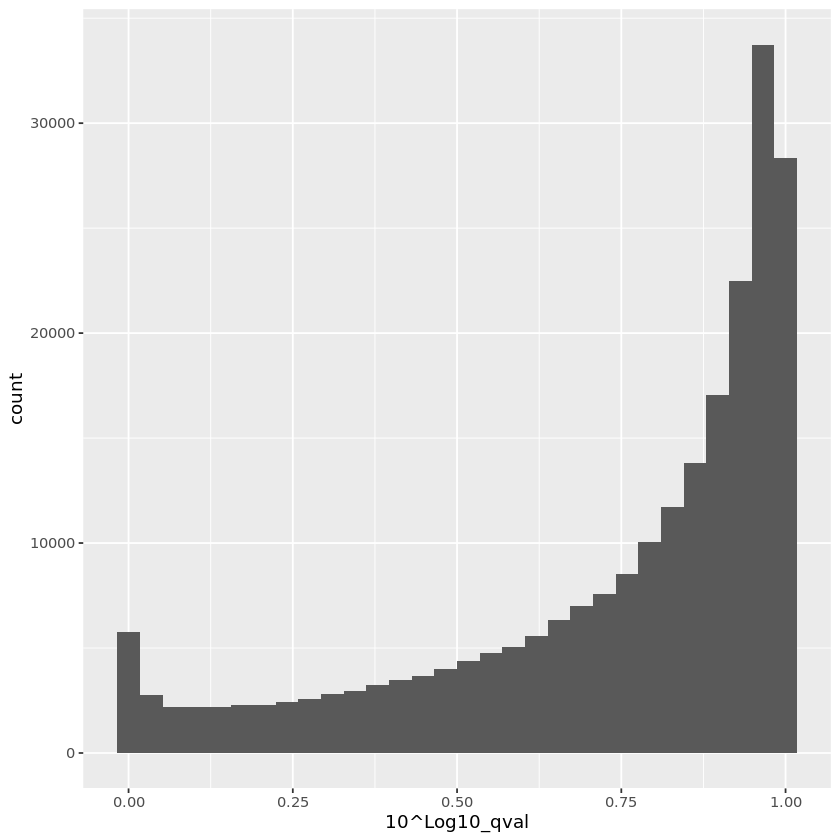

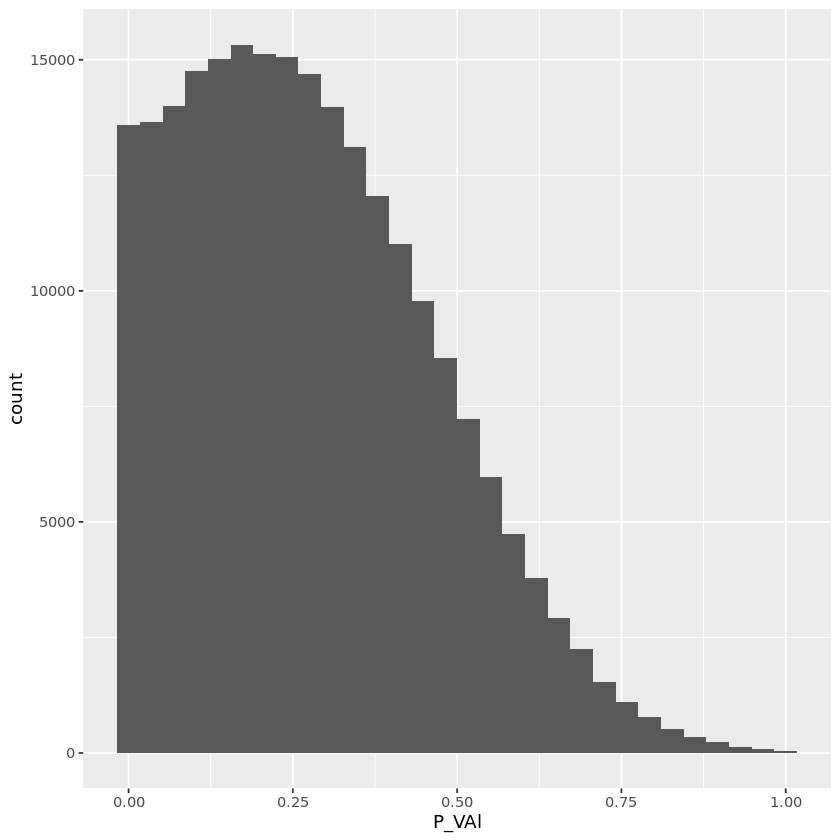

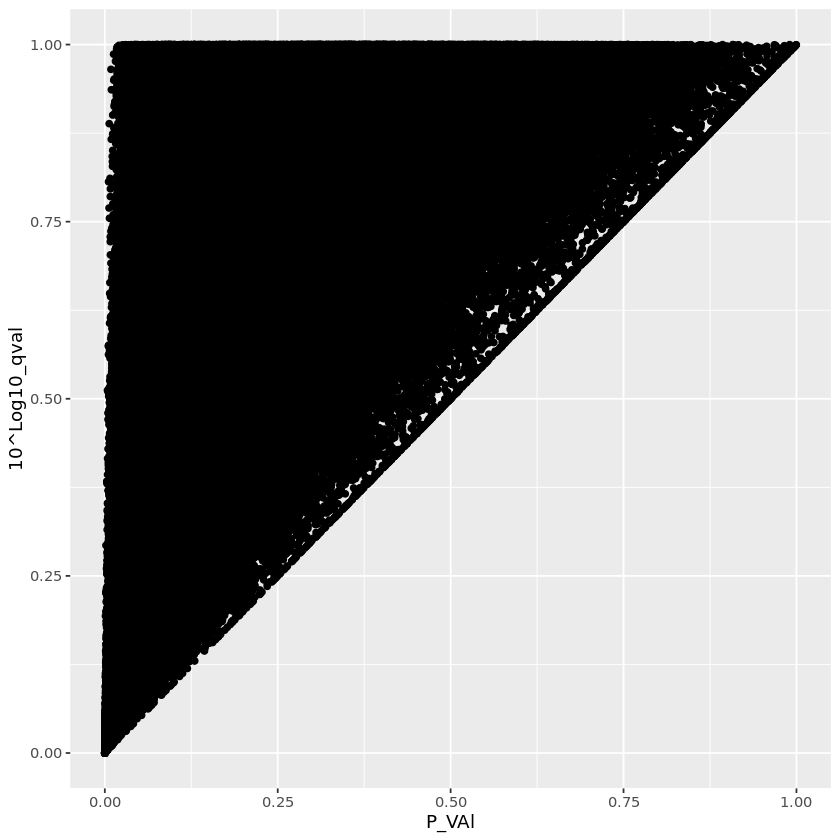

In [14]:
#library(ggplot2)
#
#ggplot(test,aes(x=Log10_qval)) + geom_histogram()
#ggplot(test,aes(x=log10(P_VAl))) + geom_histogram()
#
#ggplot(test, aes(x=log10(P_VAl), y=Log10_qval)) + geom_point()
#
#
#ggplot(test,aes(x=10^Log10_qval)) + geom_histogram()
#ggplot(test,aes(x=P_VAl)) + geom_histogram()
#
#ggplot(test, aes(x=P_VAl, y=10^Log10_qval)) + geom_point()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


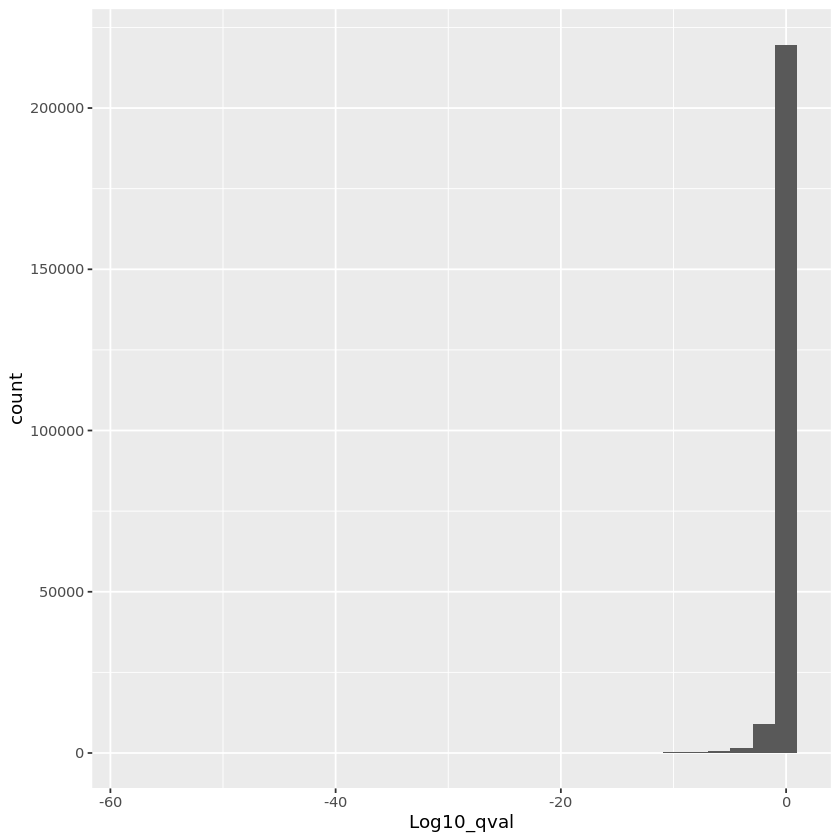

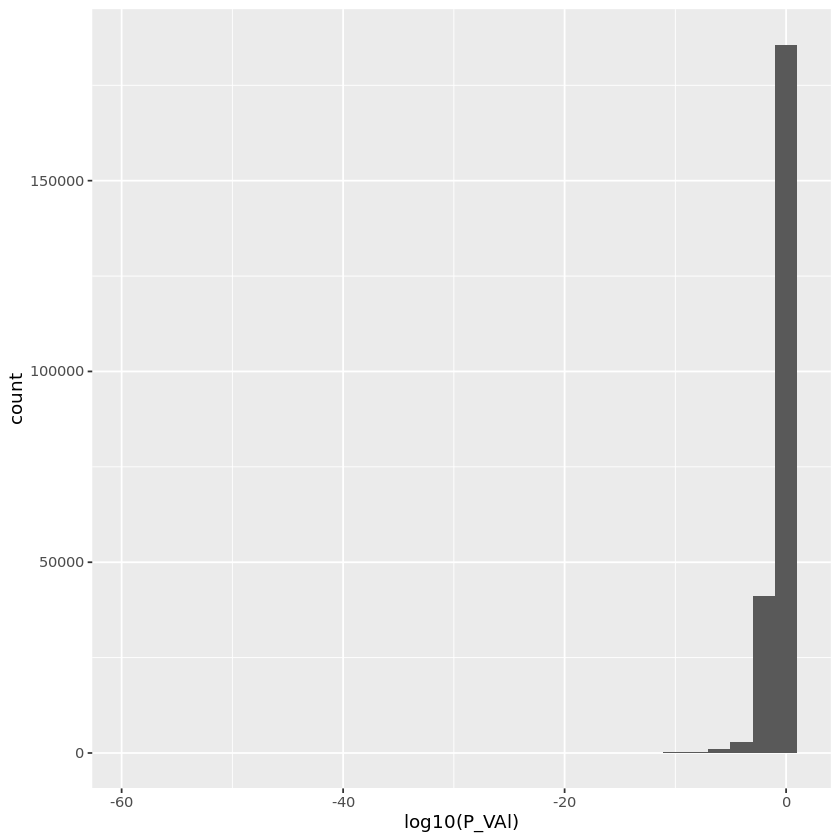

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


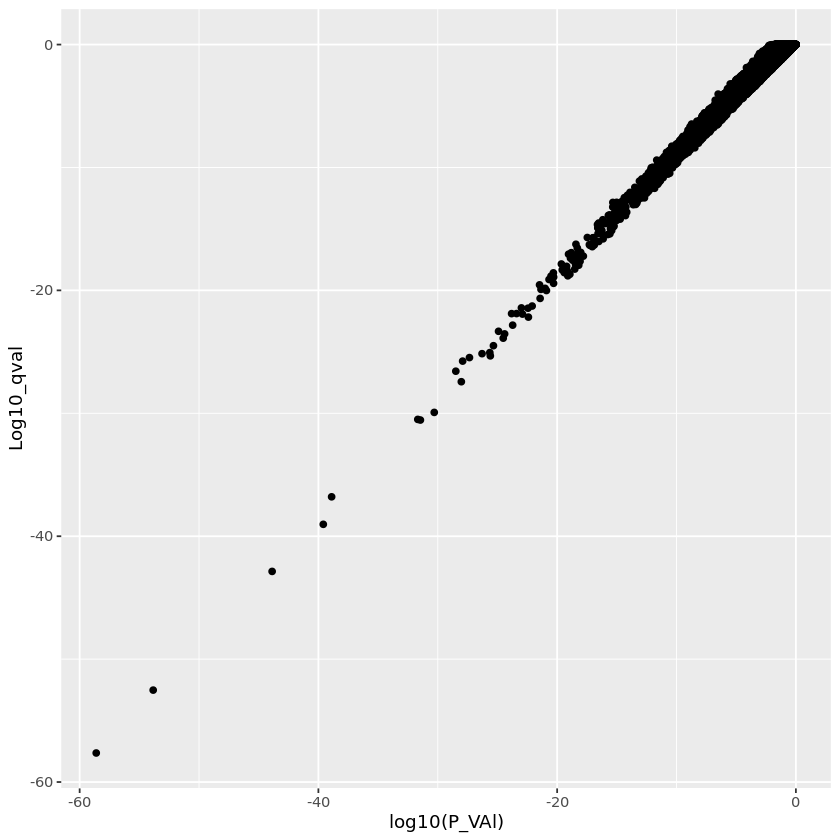

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


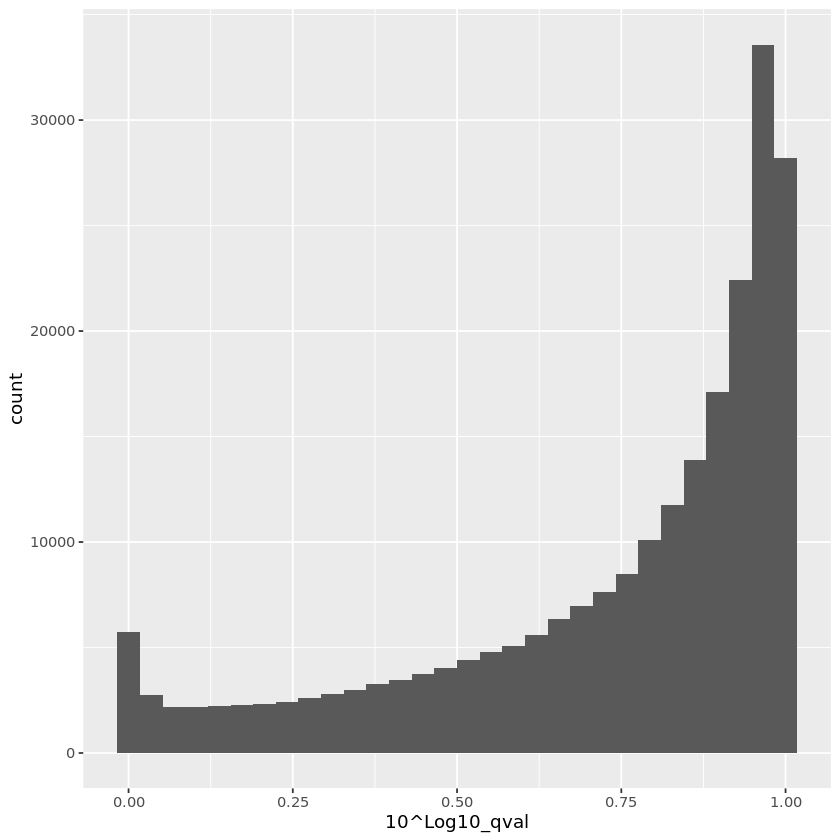

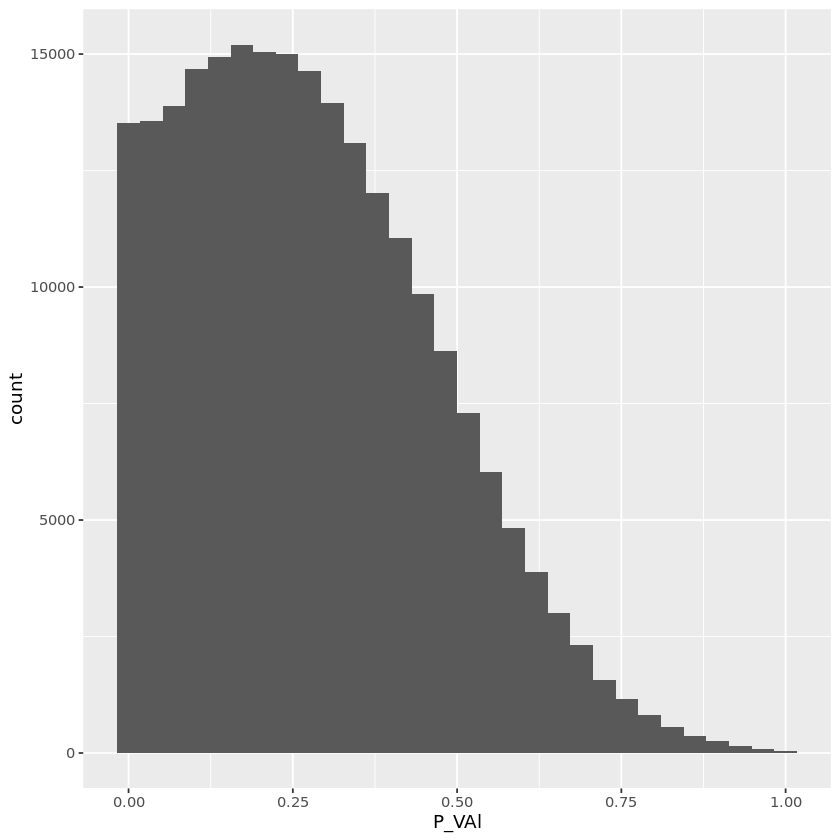

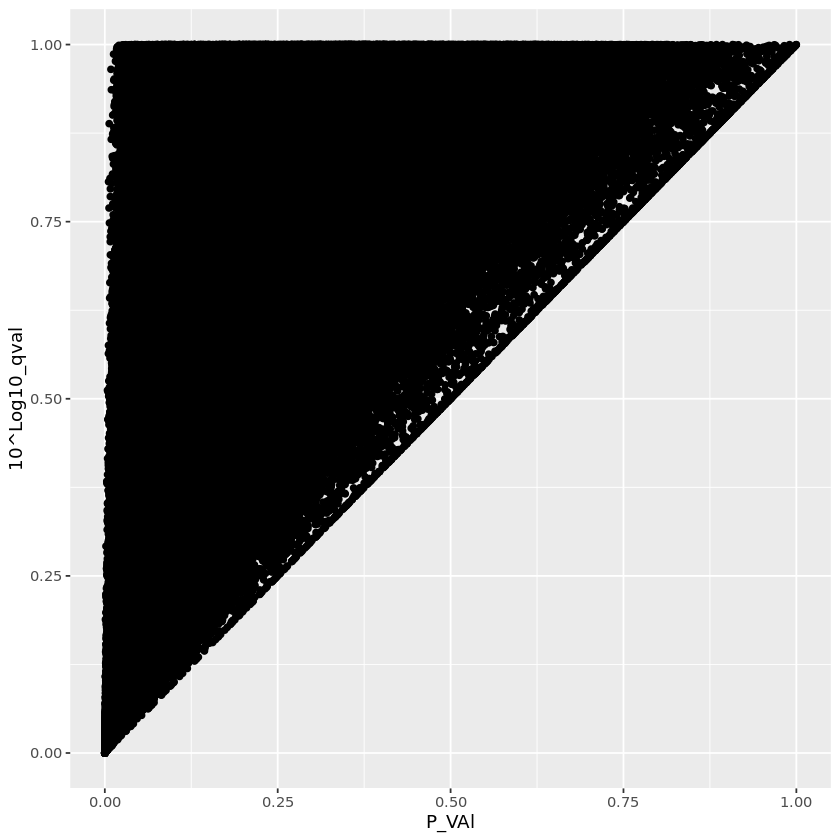

In [24]:
#library(ggplot2)
#
#ggplot(test,aes(x=Log10_qval)) + geom_histogram()
#ggplot(test,aes(x=log10(P_VAl))) + geom_histogram()
#
#ggplot(test, aes(x=log10(P_VAl), y=Log10_qval)) + geom_point()
#
#
#ggplot(test,aes(x=10^Log10_qval)) + geom_histogram()
#ggplot(test,aes(x=P_VAl)) + geom_histogram()
#
#ggplot(test, aes(x=P_VAl, y=10^Log10_qval)) + geom_point()

[1] 0.03761841

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


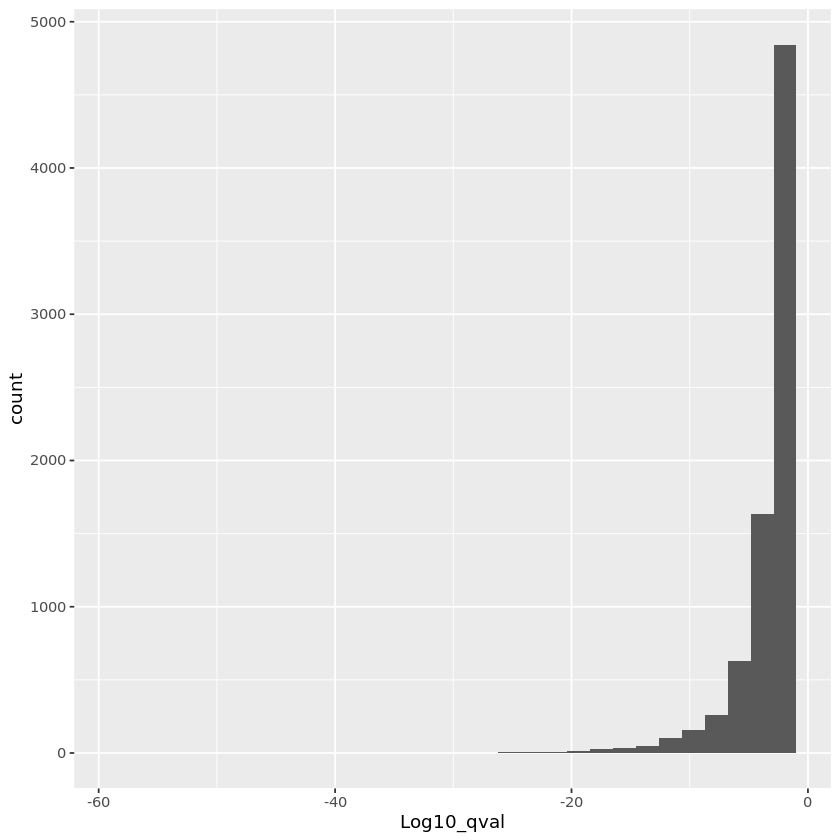

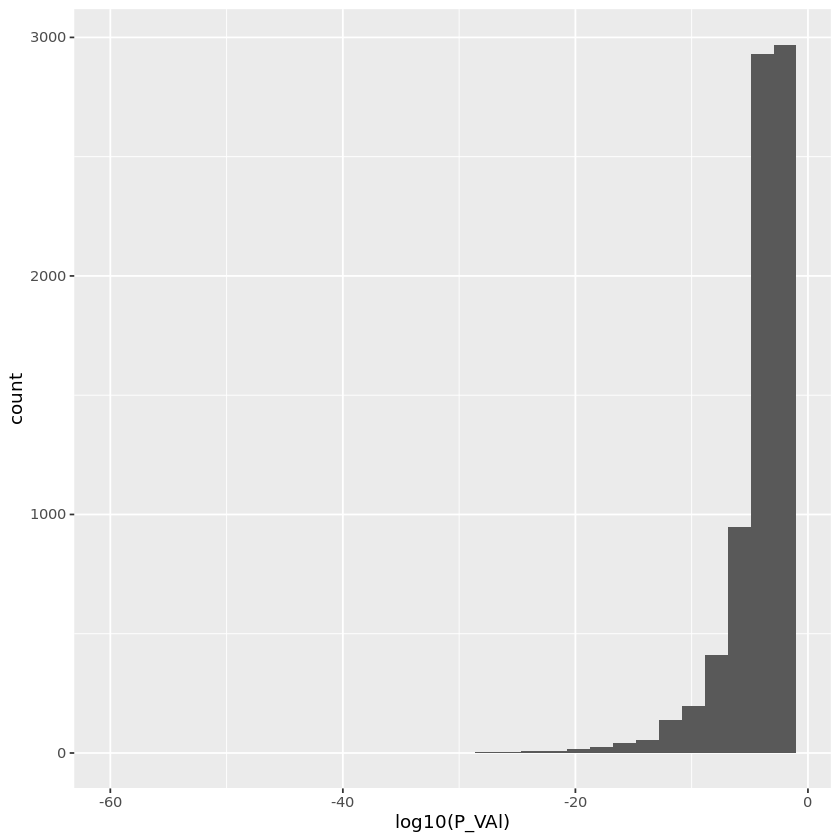

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


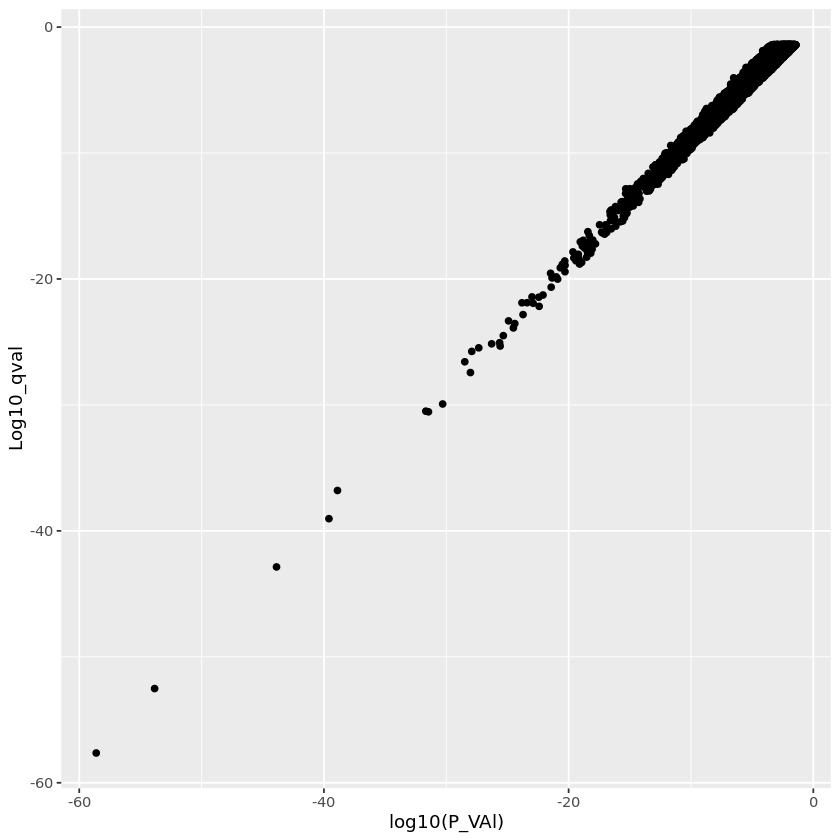

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


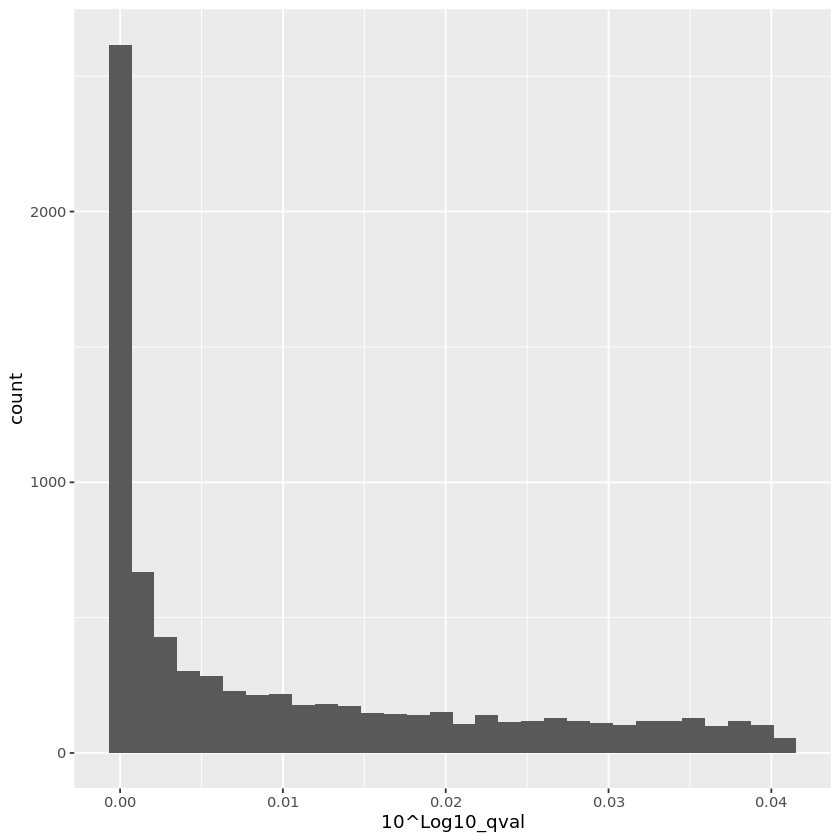

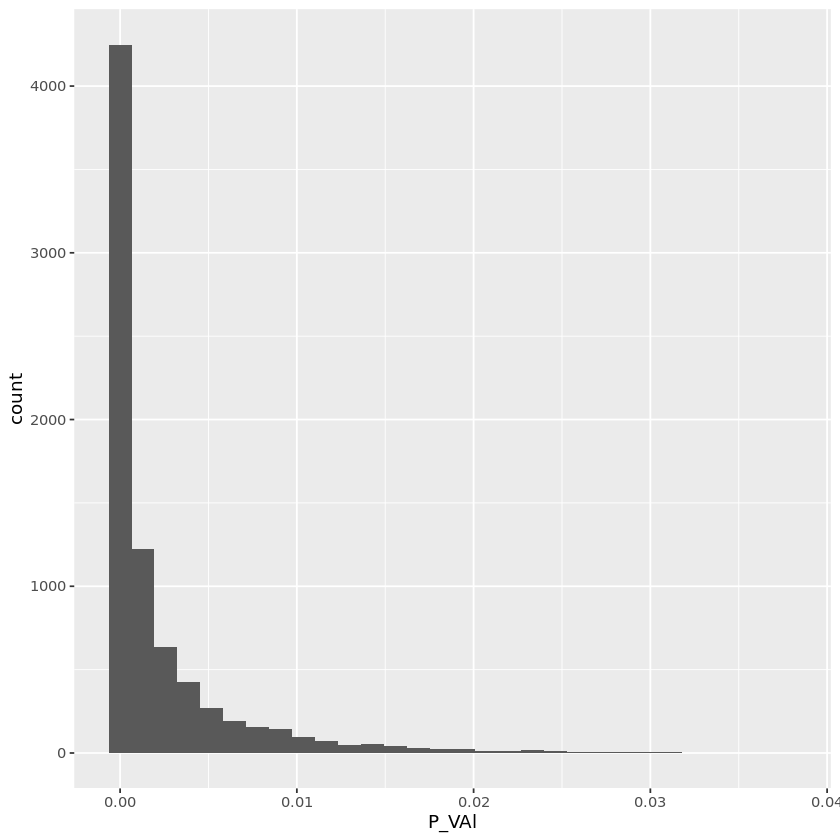

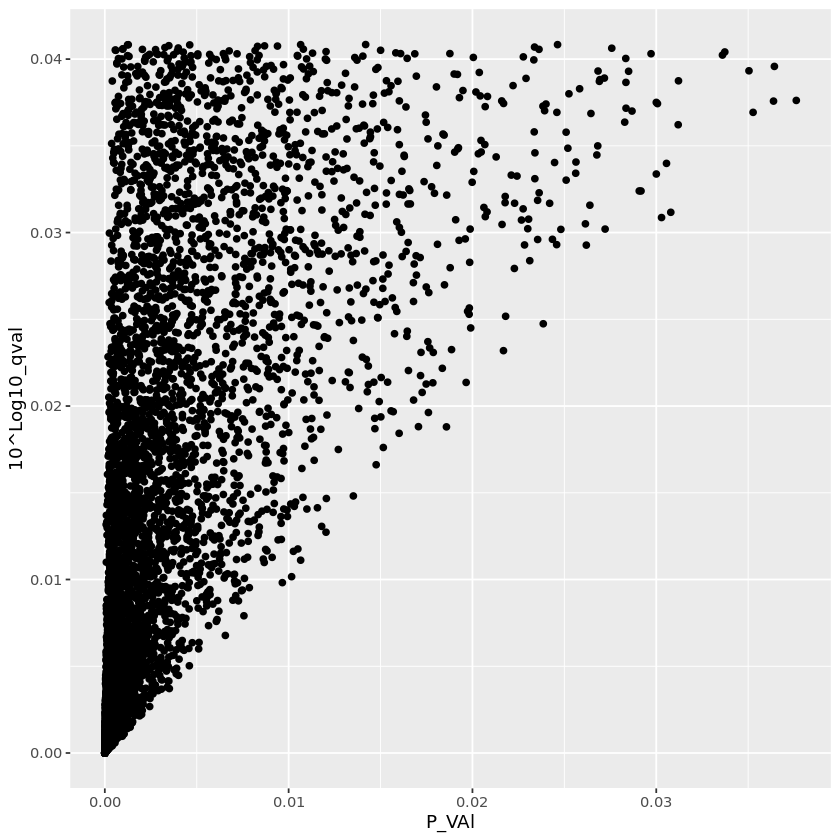

In [26]:
#test_10 <- test[test$flag_fdr10,]
#
#max(test_10$P_VAl)
#
#ggplot(test_10,aes(x=Log10_qval)) + geom_histogram()
#ggplot(test_10,aes(x=log10(P_VAl))) + geom_histogram()
#
#ggplot(test_10, aes(x=log10(P_VAl), y=Log10_qval)) + geom_point()
#
#
#ggplot(test_10,aes(x=10^Log10_qval)) + geom_histogram()
#ggplot(test_10,aes(x=P_VAl)) + geom_histogram()
#
#ggplot(test_10, aes(x=P_VAl, y=10^Log10_qval)) + geom_point()

[1] 0.01352071

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


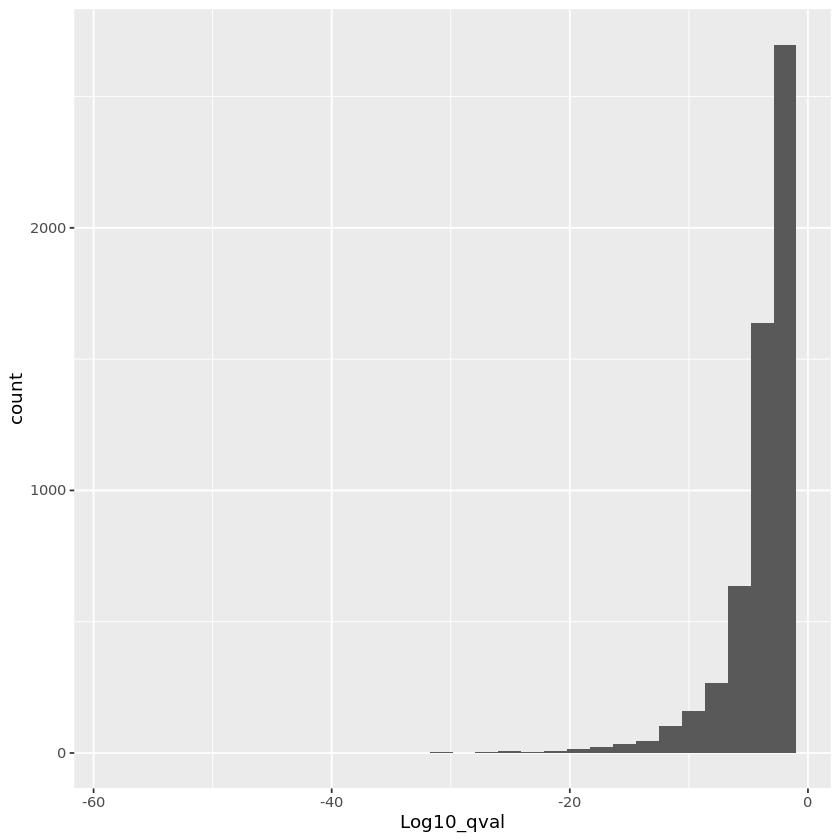

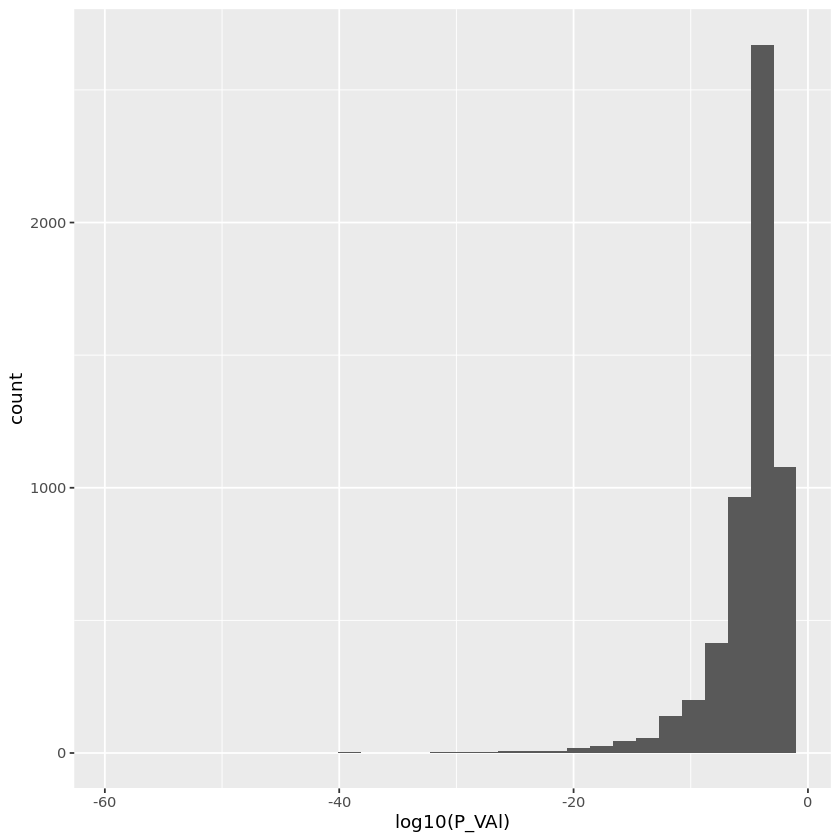

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


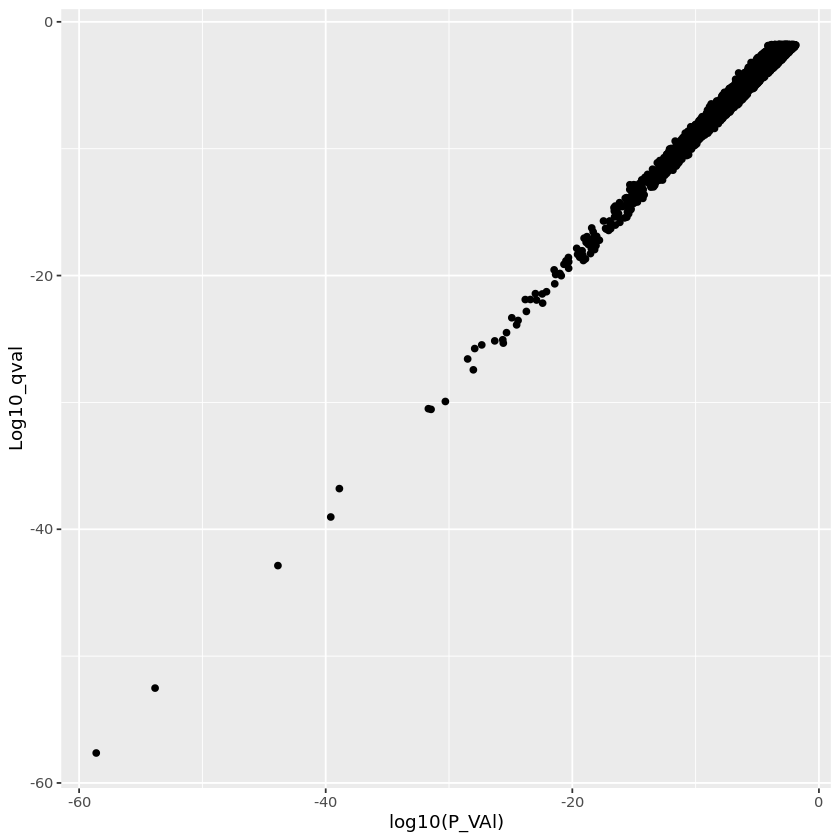

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


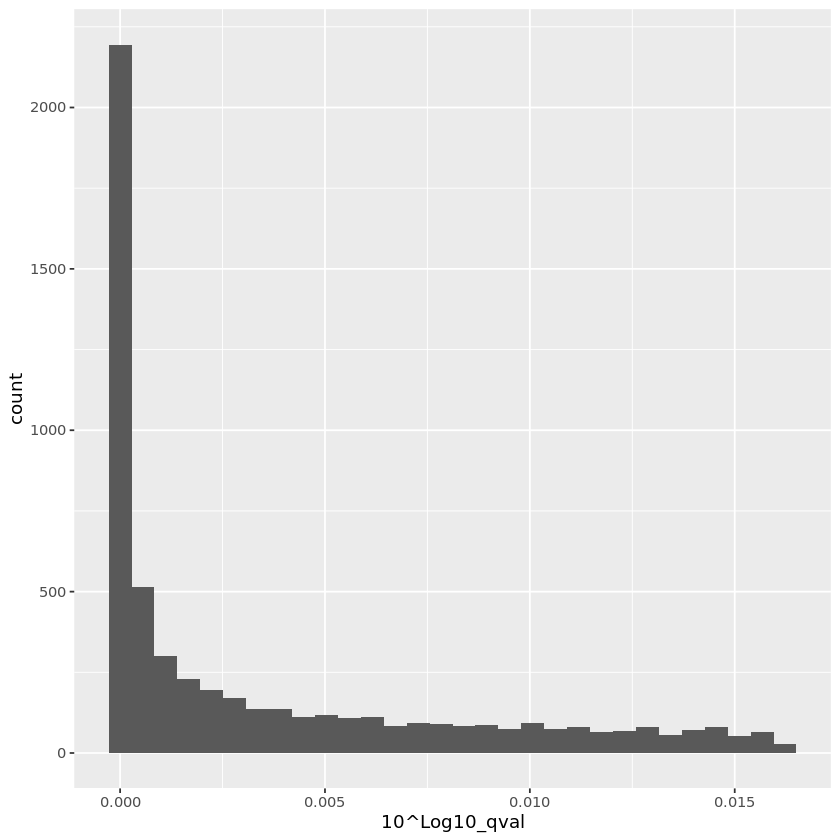

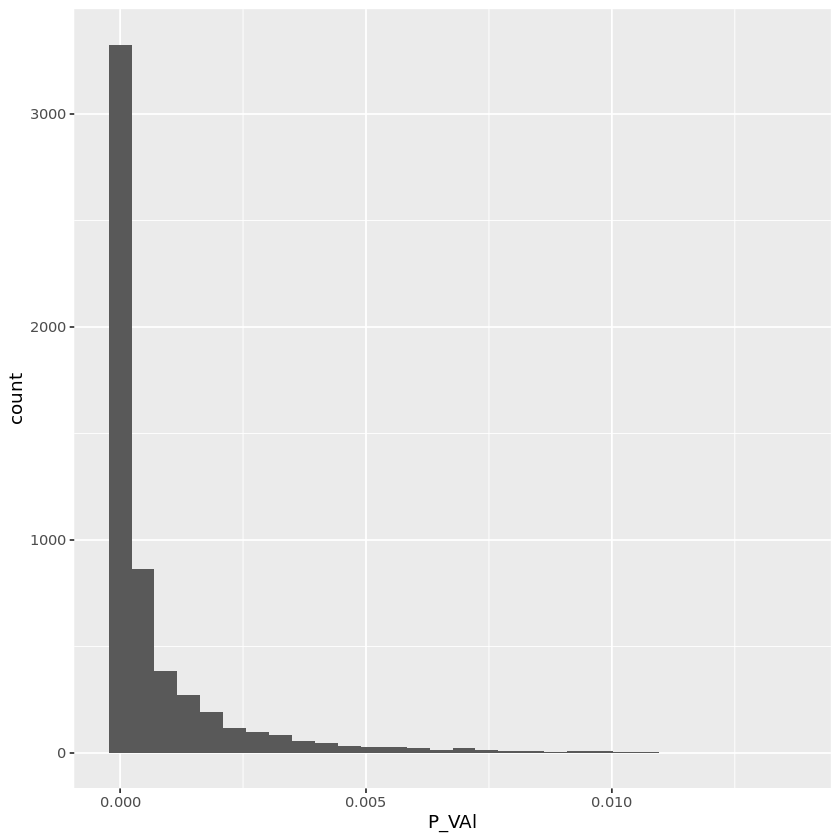

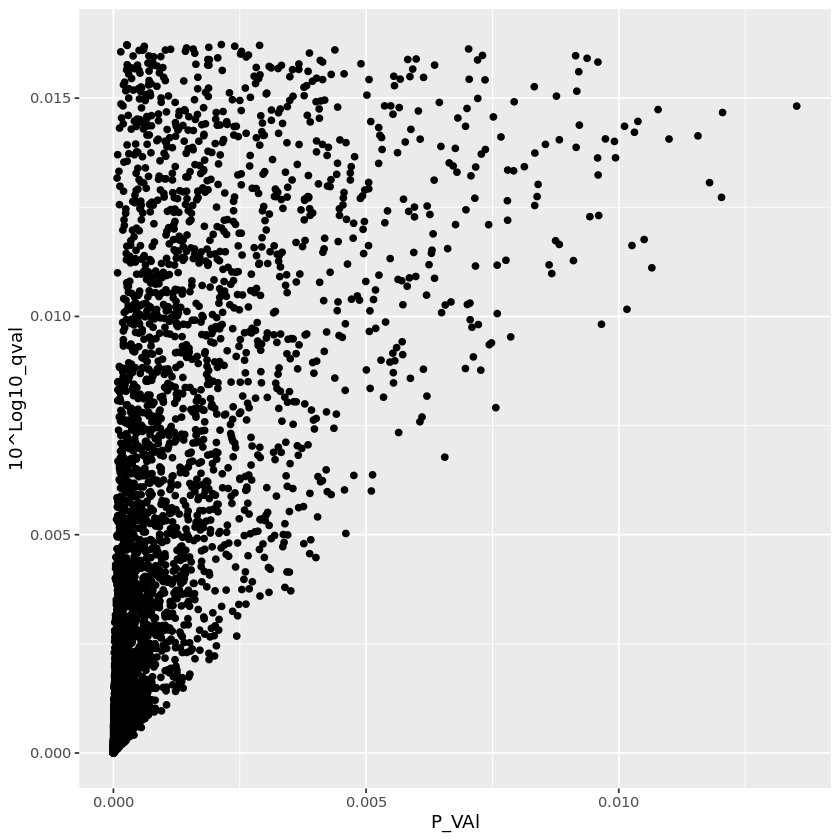

In [27]:
#test_05 <- test[test$flag_fdr05,]
#
#max(test_05$P_VAl)
#
#ggplot(test_05,aes(x=Log10_qval)) + geom_histogram()
#ggplot(test_05,aes(x=log10(P_VAl))) + geom_histogram()
#
#ggplot(test_05, aes(x=log10(P_VAl), y=Log10_qval)) + geom_point()
#
#
#ggplot(test_05,aes(x=10^Log10_qval)) + geom_histogram()
#ggplot(test_05,aes(x=P_VAl)) + geom_histogram()
#
#ggplot(test_05, aes(x=P_VAl, y=10^Log10_qval)) + geom_point()

In [25]:
#max(test$P_VAl)

[1] 0.9999029

In [29]:
df

qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01%
acinar      0.028174635  3050        0.009736167  2144        0.000325682
alpha       0.044057984  5629        0.018495615  4218        0.002634698
beta        0.042475485  7789        0.016592749  5932        0.001646814
delta       0.067561039  1262        0.033722496   877        0.007658465
ductal      0.037689747   419        0.013893899   267        0.001464991
endothelial 0.000000000     0        0.000000000     0        0.000000000
gamma       0.065126695   758        0.034380005   524        0.007940879
immune      0.039476476     9        0.020176438     4        0.020176438
stellate    0.005227418     2        0.005227418     2        0.005227418
bulk        0.041162844 16034        0.016342044 12217        0.001560898
            caQTL_fdr01% tested_features
acinar      1011          96373         
alpha       2546         107935         
beta        3657         106506         
delta        478          79636         
ductal       106          49135         
endothelial    0           1399         
gamma        274          60138         
immune         4           8173         
stellate       2          11915         
bulk        7455         252057

cell_type   qval_fdr10% caQTL_fdr10% qval_fdr05% caQTL_fdr05% qval_fdr01%
1  bulk        0.041162844 16034        0.016342044 12217        0.001560898
2  beta        0.042475485  7789        0.016592749  5932        0.001646814
3  alpha       0.044057984  5629        0.018495615  4218        0.002634698
4  acinar      0.028174635  3050        0.009736167  2144        0.000325682
5  delta       0.067561039  1262        0.033722496   877        0.007658465
6  gamma       0.065126695   758        0.034380005   524        0.007940879
7  ductal      0.037689747   419        0.013893899   267        0.001464991
8  immune      0.039476476     9        0.020176438     4        0.020176438
9  stellate    0.005227418     2        0.005227418     2        0.005227418
10 endothelial 0.000000000     0        0.000000000     0        0.000000000
   caQTL_fdr01% tested_features
1  7455         252057         
2  3657         106506         
3  2546         107935         
4  1011          96373         
5   478          79636         
6   274          60138         
7   106          49135         
8     4           8173         
9     2          11915         
10    0           1399

NULL

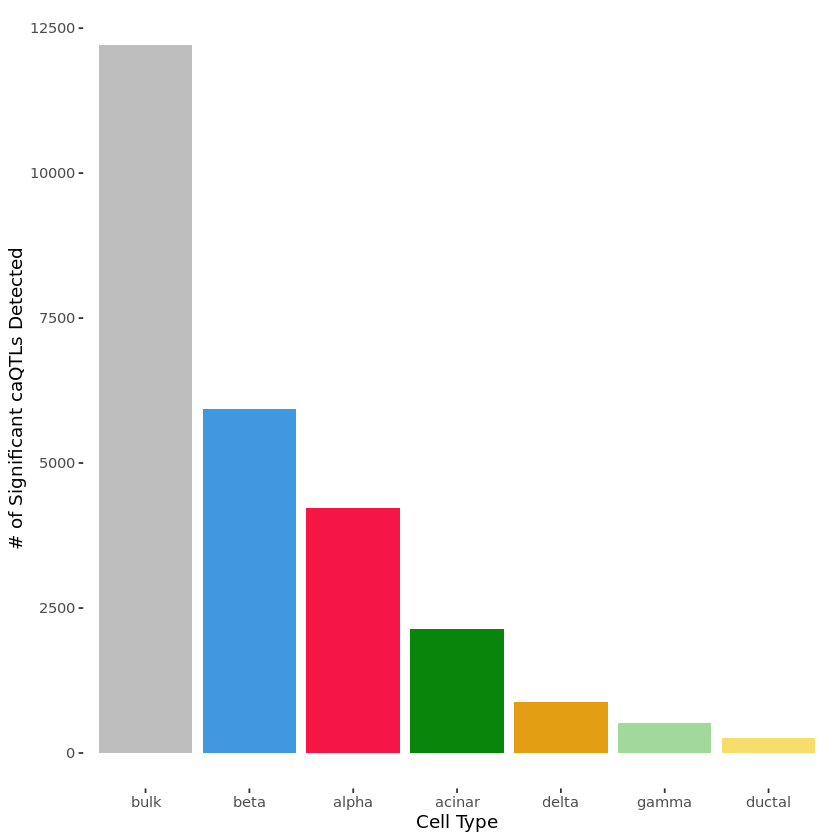

In [49]:
library(ggplot2)

results <- df
results <- dplyr::arrange(results, -`caQTL_fdr05%`)
results <- tibble::rownames_to_column(results, var='cell_type')
levels <- results$cell_type
results$cell_type <- as.factor(results$cell_type)
results$cell_type <- forcats::fct_relevel(results$cell_type, levels)

results
results$color

p1 <- ggplot(filter(results, !(cell_type %in% c('immune', 'stellate', 'endothelial'))), 
             aes(x=cell_type, y=`caQTL_fdr05%`, fill=cell_type)) + geom_col() +
    scale_fill_manual(values=c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#E39E14', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 
                 'stellate'='#FDBB84', 'bulk'='gray')) +
    theme(panel.background = element_blank(), legend.position = "none") +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected")

p1

#ggsave(plot=p1, filename="/path/to/caQTL/stuff/figures/230531_Cell_Type_caQTL_Counts.tiff", width=8, height=5)

# Run1 Stopped Here

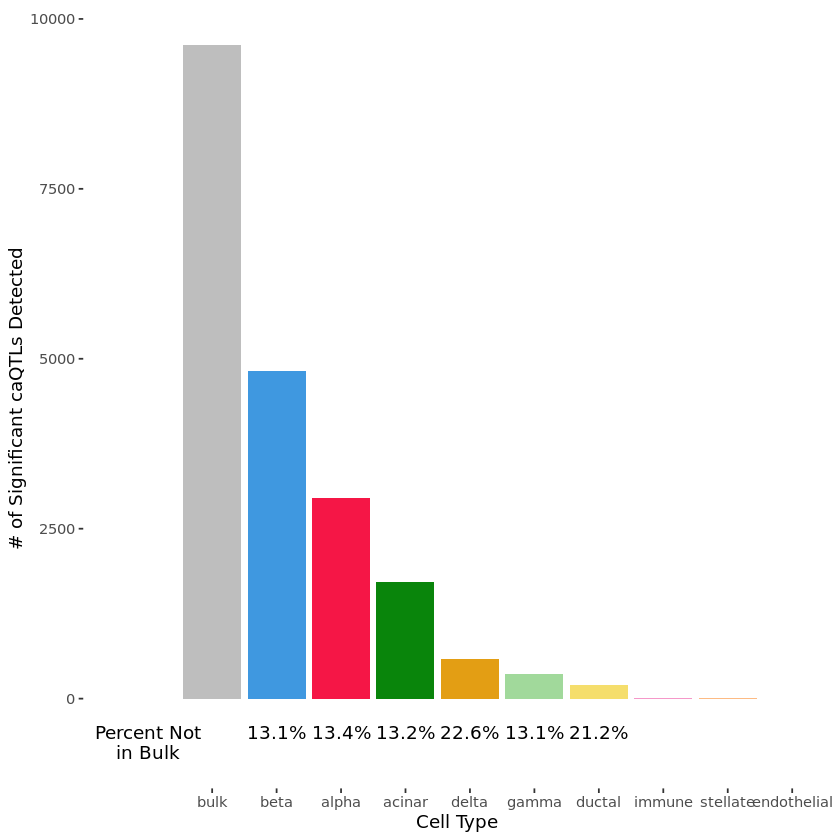

In [283]:
#p1 <- ggplot(filter(results, !(cell_type %in% c('immune', 'stellate', 'endothelial'))), 
#             aes(x=cell_type, y=`caQTL_fdr05%`, fill=cell_type)) + geom_col() +
#    scale_fill_manual(values=c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
#                 'delta'='#E39E14', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
#                 'gamma'='#A1D99B', 'immune'='#F598C9', 
#                 'stellate'='#FDBB84', 'bulk'='gray')) +
#    theme(panel.background = element_blank(), legend.position = "none") +
#    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
#    annotate(geom='Text', label="13.1%", x=2, y=-500) +
#    annotate(geom='Text', label="13.4%", x=3, y=-500) +
#    annotate(geom='Text', label="13.2%", x=4, y=-500) +
#    annotate(geom='Text', label="22.6%", x=5, y=-500) +
#    annotate(geom='Text', label="13.1%", x=6, y=-500) +
#    annotate(geom='Text', label="21.2%", x=7, y=-500) +
#    annotate(geom='Text', label="Percent Not", x=0, y=-500) +
#    annotate(geom='Text', label="in Bulk", x=0, y=-800) +
#    annotate(geom='Text', label="", x=-1, y=-800)
#p1 
#
#ggsave(plot=p1, filename="/path/to/caQTL/stuff/figures/230531_Cell_Type_caQTL_Counts.tiff", width=8, height=5)
#ggsave(plot=p1, filename="/path/to/caQTL/stuff/figures/230531_Cell_Type_caQTL_Counts.svg", width=8, height=5)

In [ ]:
#celltypes <- c('acinar','alpha','beta','delta','ductal','endothelial','gamma',
#                'immune','stellate','bulk')
#
#sig_QTLs <- data.frame()
#all_QTLs <- data.frame()
#for(c in celltypes) {
#    all <- read.table(paste0(c, '/Results_run7F_all.tsv'), header=T, stringsAsFactors = F)
#    
#    all$cell <- c
#    
#    all_QTLs <- rbind(all_QTLs, all)
#    
#    sig <- all[all$flag_fdr05,]
#    
#    sig_QTLs <- rbind(sig_QTLs, sig)
#}
#
#dim(sig_QTLs)
#head(sig_QTLs)
#
#dim(all_QTLs)
#head(all_QTLs)

In [ ]:
#sig_QTLs_no_bulk <- dplyr::filter(sig_QTLs, cell!='bulk')
#sig_QTLs_no_bulk

In [7]:
#length(unique(sig_QTLs$Feature))
#length(unique(sig_QTLs_no_bulk$Feature))

[1] 11630

[1] 7552

In [8]:
sig_QTL_Feature_cell <- select(sig_QTLs, Feature, cell)
sig_QTL_Feature_cell

sig_QTL_Feature_cell_no_bulk <- select(sig_QTLs_no_bulk, Feature, cell)
sig_QTL_Feature_cell_no_bulk

Feature                   cell  
1       chr9:6931452-6932441      acinar
2       chr9:6931452-6932441      acinar
3       chr9:6931452-6932441      acinar
4       chr9:6931452-6932441      acinar
5       chr9:6931452-6932441      acinar
6       chr9:6931452-6932441      acinar
7       chr9:6931452-6932441      acinar
8       chr9:6931452-6932441      acinar
9       chr9:6931452-6932441      acinar
10      chr9:6931452-6932441      acinar
11      chr9:6931452-6932441      acinar
12      chr9:6931452-6932441      acinar
13      chr9:6931452-6932441      acinar
14      chr9:6931452-6932441      acinar
15      chr9:6931452-6932441      acinar
16      chr9:6931452-6932441      acinar
17      chr9:6931452-6932441      acinar
18      chr9:6931452-6932441      acinar
19      chr9:6931452-6932441      acinar
20      chr9:6931452-6932441      acinar
21      chr9:6931452-6932441      acinar
22      chr9:6931452-6932441      acinar
23      chr9:6931452-6932441      acinar
24      chr9:6931452-6932441      acinar
25      chr9:6931452-6932441      acinar
26      chr9:6931452-6932441      acinar
27      chr9:6931452-6932441      acinar
28      chr9:6931452-6932441      acinar
29      chr9:6931452-6932441      acinar
30      chr9:6931452-6932441      acinar
⋮       ⋮                         ⋮     
3561041 chr11:90726202-90726714   bulk  
3561051 chr11:90726202-90726714   bulk  
3561061 chr11:90726202-90726714   bulk  
356107  chr11:90726202-90726714   bulk  
356108  chr11:90726202-90726714   bulk  
356109  chr11:90726202-90726714   bulk  
356329  chr11:90726202-90726714   bulk  
356399  chr11:90726202-90726714   bulk  
356574  chr6:46357786-46358456    bulk  
356976  chr11:90726202-90726714   bulk  
356977  chr11:90726202-90726714   bulk  
356978  chr11:90726202-90726714   bulk  
356979  chr11:90726202-90726714   bulk  
356980  chr11:90726202-90726714   bulk  
357375  chr7:158108788-158110295  bulk  
358673  chr12:124758128-124758765 bulk  
359679  chr2:130692539-130693900  bulk  
3604151 chr10:43137534-43139135   bulk  
3612011 chr19:47427262-47428636   bulk  
362684  chr2:130692539-130693900  bulk  
362738  chr8:107614398-107614835  bulk  
363146  chr8:144762184-144762853  bulk  
363288  chr2:130692539-130693900  bulk  
3633161 chr2:130692539-130693900  bulk  
363387  chr2:130692539-130693900  bulk  
3633921 chr2:130692539-130693900  bulk  
3636011 chr2:130692539-130693900  bulk  
3637321 chr2:130692539-130693900  bulk  
3638711 chr2:130692539-130693900  bulk  
3647721 chr2:130692539-130693900  bulk

Feature                cell    
1      chr9:6931452-6932441   acinar  
2      chr9:6931452-6932441   acinar  
3      chr9:6931452-6932441   acinar  
4      chr9:6931452-6932441   acinar  
5      chr9:6931452-6932441   acinar  
6      chr9:6931452-6932441   acinar  
7      chr9:6931452-6932441   acinar  
8      chr9:6931452-6932441   acinar  
9      chr9:6931452-6932441   acinar  
10     chr9:6931452-6932441   acinar  
11     chr9:6931452-6932441   acinar  
12     chr9:6931452-6932441   acinar  
13     chr9:6931452-6932441   acinar  
14     chr9:6931452-6932441   acinar  
15     chr9:6931452-6932441   acinar  
16     chr9:6931452-6932441   acinar  
17     chr9:6931452-6932441   acinar  
18     chr9:6931452-6932441   acinar  
19     chr9:6931452-6932441   acinar  
20     chr9:6931452-6932441   acinar  
21     chr9:6931452-6932441   acinar  
22     chr9:6931452-6932441   acinar  
23     chr9:6931452-6932441   acinar  
24     chr9:6931452-6932441   acinar  
25     chr9:6931452-6932441   acinar  
26     chr9:6931452-6932441   acinar  
27     chr9:6931452-6932441   acinar  
28     chr9:6931452-6932441   acinar  
29     chr9:6931452-6932441   acinar  
30     chr9:6931452-6932441   acinar  
⋮      ⋮                      ⋮       
92520  chr6:29887262-29888854 stellate
101209 chr6:29887262-29888854 stellate
111078 chr6:29887262-29888854 stellate
121027 chr6:29887262-29888854 stellate
131020 chr6:29887262-29888854 stellate
141059 chr6:29887262-29888854 stellate
161025 chr8:8227406-8229392   stellate
171009 chr8:8227406-8229392   stellate
181009 chr8:8227406-8229392   stellate
191008 chr8:8227406-8229392   stellate
201008 chr8:8227406-8229392   stellate
211009 chr8:8227406-8229392   stellate
231008 chr8:8227406-8229392   stellate
251008 chr8:8227406-8229392   stellate
301008 chr8:8227406-8229392   stellate
311008 chr8:8227406-8229392   stellate
321008 chr8:8227406-8229392   stellate
331007 chr8:8227406-8229392   stellate
341008 chr8:8227406-8229392   stellate
351008 chr8:8227406-8229392   stellate
361007 chr8:8227406-8229392   stellate
371006 chr8:8227406-8229392   stellate
381007 chr8:8227406-8229392   stellate
391007 chr8:8227406-8229392   stellate
401007 chr8:8227406-8229392   stellate
411007 chr8:8227406-8229392   stellate
421007 chr8:8227406-8229392   stellate
431007 chr8:8227406-8229392   stellate
441007 chr8:8227406-8229392   stellate
461007 chr6:29887262-29888854 stellate

In [9]:
sig_QTL_Feature_cell <- sig_QTL_Feature_cell[!duplicated(sig_QTL_Feature_cell),]
sig_QTL_Feature_cell

sig_QTL_Feature_cell_no_bulk <- sig_QTL_Feature_cell_no_bulk[!duplicated(sig_QTL_Feature_cell_no_bulk),]
sig_QTL_Feature_cell_no_bulk

Feature                   cell  
1       chr9:6931452-6932441      acinar
105     chr9:93230239-93231938    acinar
120     chr3:125990029-125991054  acinar
129     chr1:18480265-18481643    acinar
130     chr2:3041890-3043276      acinar
132     chr6:31497627-31498514    acinar
154     chr11:69088518-69089750   acinar
155     chr1:161611907-161613071  acinar
193     chr2:238231152-238231860  acinar
196     chr4:7164816-7165698      acinar
218     chr11:67825932-67827070   acinar
312     chr2:62293165-62294384    acinar
330     chr21:46477254-46478360   acinar
341     chr6:30453450-30454100    acinar
467     chr8:17607871-17609288    acinar
502     chr7:155322403-155323669  acinar
526     chr19:47648017-47649055   acinar
563     chr11:5367277-5368032     acinar
628     chr12:125982853-125984444 acinar
629     chr21:13979625-13980808   acinar
634     chr18:8799900-8801529     acinar
638     chr11:45259418-45260327   acinar
648     chr7:155214003-155215148  acinar
657     chr7:27346594-27347551    acinar
693     chr1:16677297-16678505    acinar
710     chr6:45044234-45045741    acinar
726     chr6:32666373-32666948    acinar
729     chr1:54794141-54795562    acinar
743     chr9:134010344-134011932  acinar
747     chr6:32668115-32668714    acinar
⋮       ⋮                         ⋮     
303095  chr2:126891479-126892428  bulk  
303620  chr1:185722206-185722459  bulk  
304976  chr1:70072579-70072786    bulk  
304978  chr2:51297556-51297904    bulk  
3051111 chr2:110869439-110869921  bulk  
305969  chr3:50715052-50715252    bulk  
306139  chr2:636126-637606        bulk  
3087721 chr9:97737539-97737768    bulk  
309049  chr6:52802875-52803334    bulk  
311848  chr7:141203616-141204116  bulk  
312639  chr11:34086926-34088467   bulk  
3133011 chr9:4005771-4006580      bulk  
314709  chr17:17933793-17934287   bulk  
314849  chr4:41579066-41579907    bulk  
315209  chr12:82358069-82359448   bulk  
315465  chr2:108215737-108216312  bulk  
315864  chr9:37806285-37806748    bulk  
316005  chr9:112307950-112309659  bulk  
320168  chr1:155977139-155979209  bulk  
322273  chr19:11495979-11497385   bulk  
328379  chr17:45997646-45997990   bulk  
329172  chr13:113506096-113506386 bulk  
330285  chr14:55599331-55599926   bulk  
338619  chr12:32686936-32687230   bulk  
339193  chr15:58641513-58642378   bulk  
3428131 chr15:52491453-52491653   bulk  
346450  chr22:41560679-41561670   bulk  
350067  chr1:26134629-26134830    bulk  
355053  chr11:90726202-90726714   bulk  
359679  chr2:130692539-130693900  bulk

Feature                   cell    
1       chr9:6931452-6932441      acinar  
105     chr9:93230239-93231938    acinar  
120     chr3:125990029-125991054  acinar  
129     chr1:18480265-18481643    acinar  
130     chr2:3041890-3043276      acinar  
132     chr6:31497627-31498514    acinar  
154     chr11:69088518-69089750   acinar  
155     chr1:161611907-161613071  acinar  
193     chr2:238231152-238231860  acinar  
196     chr4:7164816-7165698      acinar  
218     chr11:67825932-67827070   acinar  
312     chr2:62293165-62294384    acinar  
330     chr21:46477254-46478360   acinar  
341     chr6:30453450-30454100    acinar  
467     chr8:17607871-17609288    acinar  
502     chr7:155322403-155323669  acinar  
526     chr19:47648017-47649055   acinar  
563     chr11:5367277-5368032     acinar  
628     chr12:125982853-125984444 acinar  
629     chr21:13979625-13980808   acinar  
634     chr18:8799900-8801529     acinar  
638     chr11:45259418-45260327   acinar  
648     chr7:155214003-155215148  acinar  
657     chr7:27346594-27347551    acinar  
693     chr1:16677297-16678505    acinar  
710     chr6:45044234-45045741    acinar  
726     chr6:32666373-32666948    acinar  
729     chr1:54794141-54795562    acinar  
743     chr9:134010344-134011932  acinar  
747     chr6:32668115-32668714    acinar  
⋮       ⋮                         ⋮       
939313  chr1:20212480-20213573    gamma   
945513  chr7:65251719-65252906    gamma   
965113  chr12:55981754-55982836   gamma   
976010  chr15:78756754-78757640   gamma   
987214  chr3:183789589-183791077  gamma   
990613  chr1:207361763-207362440  gamma   
1001813 chr6:31079568-31080391    gamma   
1019910 chr11:118689318-118690634 gamma   
102598  chr5:177370475-177371370  gamma   
1036011 chr1:15595904-15597228    gamma   
1048113 chr2:88265000-88266285    gamma   
106097  chr6:13407640-13408925    gamma   
1064413 chr14:102046097-102046977 gamma   
1074710 chr7:48088238-48089928    gamma   
1100411 chr2:219357790-219359336  gamma   
111388  chr4:159174915-159176256  gamma   
1116310 chr20:62320734-62322254   gamma   
115343  chr1:236420851-236421563  gamma   
116798  chr19:246545-247530       gamma   
1183111 chr16:67362884-67364143   gamma   
1267112 chr8:144762184-144762853  gamma   
126805  chr7:66015376-66016789    gamma   
128675  chr10:100561831-100563289 gamma   
134747  chr5:77775372-77776814    gamma   
141295  chr4:142934572-142935233  gamma   
158164  chr12:31073368-31074875   gamma   
110030  chr8:8227406-8229392      immune  
181008  chr8:17922161-17924249    immune  
85847   chr6:29887262-29888854    stellate
161025  chr8:8227406-8229392      stellate

In [10]:
celltypes_to_graph <- c('acinar','alpha','beta','delta','ductal','gamma','bulk')
celltypes_to_graph_no_bulk <- c('acinar','alpha','beta','delta','ductal','gamma')

In [11]:
data.frame(table(sig_QTL_Feature_cell[!duplicated(sig_QTL_Feature_cell$Feature),]$cell)[celltypes_to_graph], Type=rep("Unique",length(celltypes_to_graph)))

data.frame(table(sig_QTL_Feature_cell_no_bulk[!duplicated(sig_QTL_Feature_cell_no_bulk$Feature),]$cell)[celltypes_to_graph_no_bulk], Type=rep("Unique",length(celltypes_to_graph_no_bulk)))

Var1   Freq Type  
1 acinar 1721 Unique
2 alpha  2492 Unique
3 beta   3111 Unique
4 delta   102 Unique
5 ductal   72 Unique
6 gamma    53 Unique
7 bulk   4078 Unique

Var1   Freq Type  
1 acinar 1721 Unique
2 alpha  2492 Unique
3 beta   3111 Unique
4 delta   102 Unique
5 ductal   72 Unique
6 gamma    53 Unique

In [40]:
# Testing
data.frame(table(filter(mutate(group_by(sig_QTL_Feature_cell, Feature), count=n()), count==1)$cell)[celltypes_to_graph], Type=rep("Unique",length(celltypes_to_graph)))
data.frame(table(sig_QTL_Feature_cell$cell)[celltypes_to_graph], Type=rep("Total",length(celltypes_to_graph)))
data.frame(table(filter(sig_QTL_Feature_cell, 
                        !(Feature %in% filter(mutate(group_by(sig_QTL_Feature_cell, Feature), count=n()), count==1)$Feature))$cell)[celltypes_to_graph],
           Type=rep("Shared",length(celltypes_to_graph)))

data.frame(table(filter(sig_QTL_Feature_cell, 
                        !(Feature %in% filter(sig_QTL_Feature_cell, cell=='bulk')$Feature))$cell)[celltypes_to_graph],
           Type=rep("Not in Bulk",length(celltypes_to_graph)))
data.frame(table(filter(sig_QTL_Feature_cell, 
                        (Feature %in% filter(sig_QTL_Feature_cell, cell=='bulk')$Feature))$cell)[celltypes_to_graph],
           Type=rep("In Bulk",length(celltypes_to_graph)))

data.frame(table(filter(mutate(group_by(filter(sig_QTL_Feature_cell, cell != 'bulk'), Feature), count=n()), count==1)$cell)[celltypes_to_graph], 
           Type=rep("Unique (Excluding Bulk)",length(celltypes_to_graph)))

data.frame(table(filter(filter(sig_QTL_Feature_cell, cell != 'bulk'), 
                        !(Feature %in% filter(mutate(group_by(filter(sig_QTL_Feature_cell, cell != 'bulk'), Feature), count=n()), count==1)$Feature))$cell)[celltypes_to_graph],
           Type=rep("Shared (Excluding Bulk)",length(celltypes_to_graph)))

Var1   Freq Type  
1 acinar  469 Unique
2 alpha   450 Unique
3 beta    832 Unique
4 delta    59 Unique
5 ductal   43 Unique
6 gamma    41 Unique
7 bulk   4078 Unique

Var1   Freq Type 
1 acinar 1721 Total
2 alpha  2950 Total
3 beta   4814 Total
4 delta   590 Total
5 ductal  206 Total
6 gamma   357 Total
7 bulk   9623 Total

Var1   Freq Type  
1 acinar 1252 Shared
2 alpha  2500 Shared
3 beta   3982 Shared
4 delta   531 Shared
5 ductal  163 Shared
6 gamma   316 Shared
7 bulk   5545 Shared

Var1   Freq Type       
1 acinar 506  Not in Bulk
2 alpha  518  Not in Bulk
3 beta   908  Not in Bulk
4 delta   89  Not in Bulk
5 ductal  57  Not in Bulk
6 gamma   56  Not in Bulk
7 NA      NA  Not in Bulk

Var1   Freq Type   
1 acinar 1215 In Bulk
2 alpha  2432 In Bulk
3 beta   3906 In Bulk
4 delta   501 In Bulk
5 ductal  149 In Bulk
6 gamma   301 In Bulk
7 bulk   9623 In Bulk

Var1   Freq Type                   
1 acinar 1056 Unique (Excluding Bulk)
2 alpha  1253 Unique (Excluding Bulk)
3 beta   2980 Unique (Excluding Bulk)
4 delta    98 Unique (Excluding Bulk)
5 ductal   70 Unique (Excluding Bulk)
6 gamma    53 Unique (Excluding Bulk)
7 NA       NA Unique (Excluding Bulk)

Var1   Freq Type                   
1 acinar  665 Shared (Excluding Bulk)
2 alpha  1697 Shared (Excluding Bulk)
3 beta   1834 Shared (Excluding Bulk)
4 delta   492 Shared (Excluding Bulk)
5 ductal  136 Shared (Excluding Bulk)
6 gamma   304 Shared (Excluding Bulk)
7 NA       NA Shared (Excluding Bulk)

In [76]:
# Testing
sig_QTL_Unique <- data.frame(table(filter(mutate(group_by(sig_QTL_Feature_cell, Feature), count=n()), count==1)$cell)[celltypes_to_graph], Type=rep("Unique",length(celltypes_to_graph)))
sig_QTL_Total <- data.frame(table(sig_QTL_Feature_cell$cell)[celltypes_to_graph], Type=rep("Total",length(celltypes_to_graph)))
sig_QTL_Shared <- data.frame(table(filter(sig_QTL_Feature_cell, 
                        !(Feature %in% filter(mutate(group_by(sig_QTL_Feature_cell, Feature), count=n()), count==1)$Feature))$cell)[celltypes_to_graph],
           Type=rep("Shared",length(celltypes_to_graph)))

sig_QTL_Not_in_Bulk <- data.frame(table(filter(sig_QTL_Feature_cell, 
                        !(Feature %in% filter(sig_QTL_Feature_cell, cell=='bulk')$Feature))$cell)[celltypes_to_graph],
           Type=rep("Not in Bulk",length(celltypes_to_graph)))
sig_QTL_In_Bulk <- data.frame(table(filter(sig_QTL_Feature_cell, 
                        (Feature %in% filter(sig_QTL_Feature_cell, cell=='bulk')$Feature))$cell)[celltypes_to_graph],
           Type=rep("In Bulk",length(celltypes_to_graph)))

sig_QTL_Unique_Excluding_Bulk <- data.frame(table(filter(mutate(group_by(filter(sig_QTL_Feature_cell, cell != 'bulk'), Feature), count=n()), count==1)$cell)[celltypes_to_graph], 
           Type=rep("Unique (Excluding Bulk)",length(celltypes_to_graph)))

sig_QTL_Shared_Excluding_Bulk <- data.frame(table(filter(filter(sig_QTL_Feature_cell, cell != 'bulk'), 
                        !(Feature %in% filter(mutate(group_by(filter(sig_QTL_Feature_cell, cell != 'bulk'), Feature), count=n()), count==1)$Feature))$cell)[celltypes_to_graph],
           Type=rep("Shared (Excluding Bulk)",length(celltypes_to_graph)))

summary_sig_QTLs <- data.frame(celltype=celltypes_to_graph, Unique=sig_QTL_Unique$Freq,
          Total=sig_QTL_Total$Freq, Shared=sig_QTL_Shared$Freq,
          Not_In_Bulk=sig_QTL_Not_in_Bulk$Freq, In_Bulk=sig_QTL_In_Bulk$Freq,
          Unique_Excluding_Bulk=sig_QTL_Unique_Excluding_Bulk$Freq,
          Shared_Excluding_Bulk=sig_QTL_Shared_Excluding_Bulk$Freq)

summary_sig_QTLs <- arrange(summary_sig_QTLs, -Unique)
summary_sig_QTLs
summary_sig_QTLs_no_bulk <- filter(summary_sig_QTLs, celltype!='bulk')
summary_sig_QTLs_no_bulk$celltype <- factor(summary_sig_QTLs_no_bulk$celltype, levels=summary_sig_QTLs_no_bulk$celltype)
summary_sig_QTLs_no_bulk
summary_sig_QTLs_no_bulk$celltype

celltype Unique Total Shared Not_In_Bulk In_Bulk Unique_Excluding_Bulk
1 bulk     4078   9623  5545    NA         9623      NA                 
2 beta      832   4814  3982   908         3906    2980                 
3 acinar    469   1721  1252   506         1215    1056                 
4 alpha     450   2950  2500   518         2432    1253                 
5 delta      59    590   531    89          501      98                 
6 ductal     43    206   163    57          149      70                 
7 gamma      41    357   316    56          301      53                 
  Shared_Excluding_Bulk
1   NA                 
2 1834                 
3  665                 
4 1697                 
5  492                 
6  136                 
7  304

celltype Unique Total Shared Not_In_Bulk In_Bulk Unique_Excluding_Bulk
1 beta     832    4814  3982   908         3906    2980                 
2 acinar   469    1721  1252   506         1215    1056                 
3 alpha    450    2950  2500   518         2432    1253                 
4 delta     59     590   531    89          501      98                 
5 ductal    43     206   163    57          149      70                 
6 gamma     41     357   316    56          301      53                 
  Shared_Excluding_Bulk
1 1834                 
2  665                 
3 1697                 
4  492                 
5  136                 
6  304

[1] beta   acinar alpha  delta  ductal gamma 
Levels: beta acinar alpha delta ductal gamma

In [78]:
write.table(summary_sig_QTLs, "/path/to/caQTL/stuff/figures/230622_WE_QTL_Celltype_Summary_For_Bar_Plot.tsv",
           sep="\t", col.names=TRUE, row.names=FALSE, quote=FALSE)
write.table(summary_sig_QTLs_no_bulk, "/path/to/caQTL/stuff/figures/230622_WE_QTL_Celltype_Summary_For_Bar_Plot_no_bulk.tsv",
           sep="\t", col.names=TRUE, row.names=FALSE, quote=FALSE)

In [97]:
summary_sig_QTLs_to_graph <- tidyr::pivot_longer(summary_sig_QTLs, cols=colnames(summary_sig_QTLs)[2:ncol(summary_sig_QTLs)], names_to="Type", values_to="Value")
summary_sig_QTLs_to_graph_no_bulk <- tidyr::pivot_longer(summary_sig_QTLs_no_bulk, cols=colnames(summary_sig_QTLs_no_bulk)[2:ncol(summary_sig_QTLs_no_bulk)], names_to="Type", values_to="Value")

In [98]:
summary_sig_QTLs_to_graph_no_bulk
summary_sig_QTLs_to_graph_no_bulk$Type <- factor(summary_sig_QTLs_to_graph_no_bulk$Type,
                                                levels=arrange(filter(summary_sig_QTLs_to_graph_no_bulk, celltype=='beta'),
                                                              Value)$Type)
summary_sig_QTLs_to_graph_no_bulk$Type
summary_sig_QTLs_to_graph_no_bulk <- arrange(summary_sig_QTLs_to_graph_no_bulk, celltype)
summary_sig_QTLs_to_graph_no_bulk

celltype Type                  Value
1  beta     Unique                 832 
2  beta     Total                 4814 
3  beta     Shared                3982 
4  beta     Not_In_Bulk            908 
5  beta     In_Bulk               3906 
6  beta     Unique_Excluding_Bulk 2980 
7  beta     Shared_Excluding_Bulk 1834 
8  acinar   Unique                 469 
9  acinar   Total                 1721 
10 acinar   Shared                1252 
11 acinar   Not_In_Bulk            506 
12 acinar   In_Bulk               1215 
13 acinar   Unique_Excluding_Bulk 1056 
14 acinar   Shared_Excluding_Bulk  665 
15 alpha    Unique                 450 
16 alpha    Total                 2950 
17 alpha    Shared                2500 
18 alpha    Not_In_Bulk            518 
19 alpha    In_Bulk               2432 
20 alpha    Unique_Excluding_Bulk 1253 
21 alpha    Shared_Excluding_Bulk 1697 
22 delta    Unique                  59 
23 delta    Total                  590 
24 delta    Shared                 531 
25 delta    Not_In_Bulk             89 
26 delta    In_Bulk                501 
27 delta    Unique_Excluding_Bulk   98 
28 delta    Shared_Excluding_Bulk  492 
29 ductal   Unique                  43 
30 ductal   Total                  206 
31 ductal   Shared                 163 
32 ductal   Not_In_Bulk             57 
33 ductal   In_Bulk                149 
34 ductal   Unique_Excluding_Bulk   70 
35 ductal   Shared_Excluding_Bulk  136 
36 gamma    Unique                  41 
37 gamma    Total                  357 
38 gamma    Shared                 316 
39 gamma    Not_In_Bulk             56 
40 gamma    In_Bulk                301 
41 gamma    Unique_Excluding_Bulk   53 
42 gamma    Shared_Excluding_Bulk  304

[1] Unique                Total                 Shared               
 [4] Not_In_Bulk           In_Bulk               Unique_Excluding_Bulk
 [7] Shared_Excluding_Bulk Unique                Total                
[10] Shared                Not_In_Bulk           In_Bulk              
[13] Unique_Excluding_Bulk Shared_Excluding_Bulk Unique               
[16] Total                 Shared                Not_In_Bulk          
[19] In_Bulk               Unique_Excluding_Bulk Shared_Excluding_Bulk
[22] Unique                Total                 Shared               
[25] Not_In_Bulk           In_Bulk               Unique_Excluding_Bulk
[28] Shared_Excluding_Bulk Unique                Total                
[31] Shared                Not_In_Bulk           In_Bulk              
[34] Unique_Excluding_Bulk Shared_Excluding_Bulk Unique               
[37] Total                 Shared                Not_In_Bulk          
[40] In_Bulk               Unique_Excluding_Bulk Shared_Excluding_Bulk
7 Levels: Unique Not_In_Bulk Shared_Excluding_Bulk ... Total

celltype Type                  Value
1  beta     Unique                 832 
2  beta     Total                 4814 
3  beta     Shared                3982 
4  beta     Not_In_Bulk            908 
5  beta     In_Bulk               3906 
6  beta     Unique_Excluding_Bulk 2980 
7  beta     Shared_Excluding_Bulk 1834 
8  acinar   Unique                 469 
9  acinar   Total                 1721 
10 acinar   Shared                1252 
11 acinar   Not_In_Bulk            506 
12 acinar   In_Bulk               1215 
13 acinar   Unique_Excluding_Bulk 1056 
14 acinar   Shared_Excluding_Bulk  665 
15 alpha    Unique                 450 
16 alpha    Total                 2950 
17 alpha    Shared                2500 
18 alpha    Not_In_Bulk            518 
19 alpha    In_Bulk               2432 
20 alpha    Unique_Excluding_Bulk 1253 
21 alpha    Shared_Excluding_Bulk 1697 
22 delta    Unique                  59 
23 delta    Total                  590 
24 delta    Shared                 531 
25 delta    Not_In_Bulk             89 
26 delta    In_Bulk                501 
27 delta    Unique_Excluding_Bulk   98 
28 delta    Shared_Excluding_Bulk  492 
29 ductal   Unique                  43 
30 ductal   Total                  206 
31 ductal   Shared                 163 
32 ductal   Not_In_Bulk             57 
33 ductal   In_Bulk                149 
34 ductal   Unique_Excluding_Bulk   70 
35 ductal   Shared_Excluding_Bulk  136 
36 gamma    Unique                  41 
37 gamma    Total                  357 
38 gamma    Shared                 316 
39 gamma    Not_In_Bulk             56 
40 gamma    In_Bulk                301 
41 gamma    Unique_Excluding_Bulk   53 
42 gamma    Shared_Excluding_Bulk  304

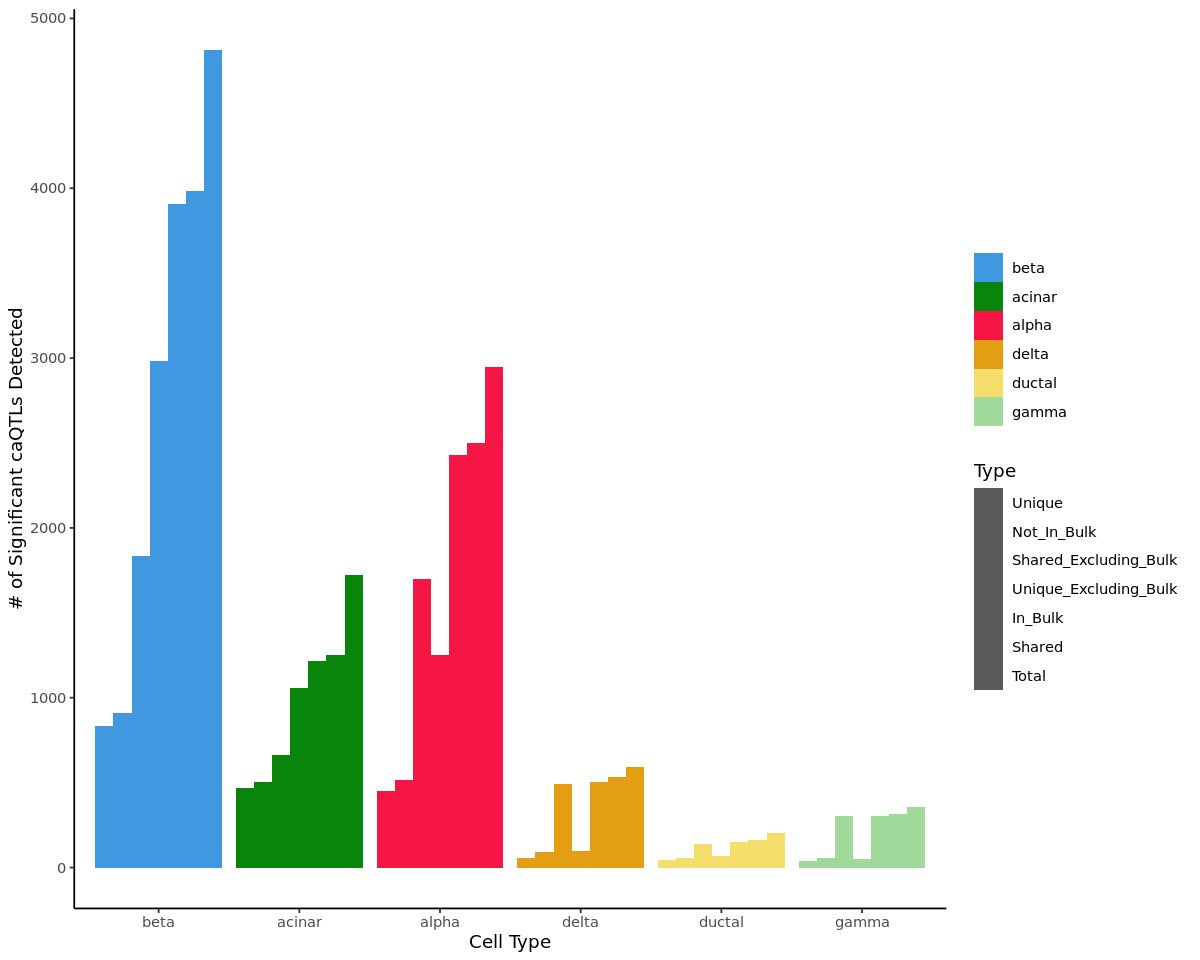

In [99]:
#pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft.svg",
#   width=6, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(summary_sig_QTLs_to_graph_no_bulk, aes(x=celltype, y=Value, fill=celltype, color = Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#E39E14', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 
                 'stellate'='#FDBB84', 'bulk'='gray')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    #scale_alpha_manual(values=c(0.6, 1)) +
    labs(fill = "", alpha="")
#p1

#dev.off()

p1

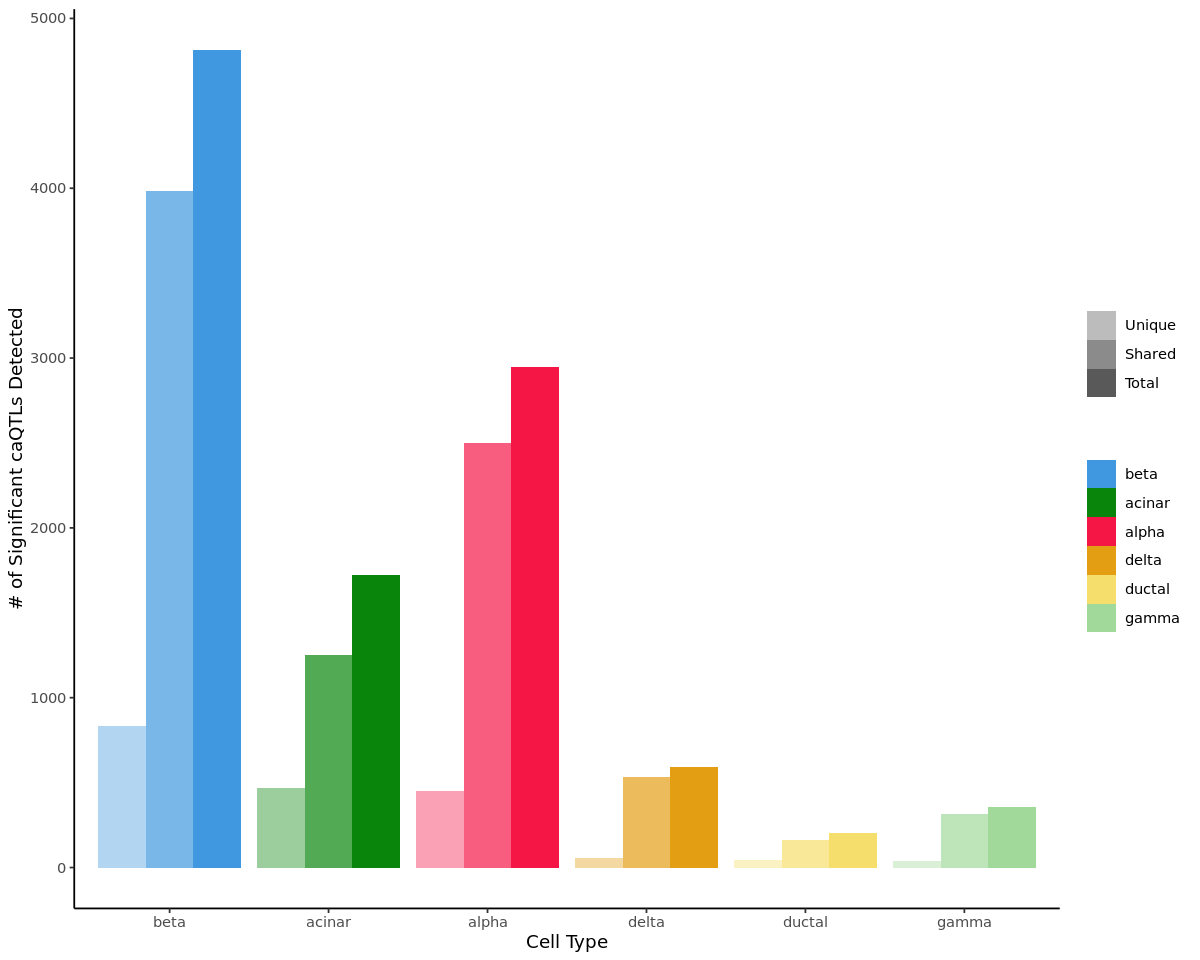

In [131]:
#pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft.svg",
#   width=6, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(filter(summary_sig_QTLs_to_graph_no_bulk, Type %in% c('Unique','Shared','Total')), 
             aes(x=celltype, y=Value, fill=celltype, alpha=Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#E39E14', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 
                 'stellate'='#FDBB84', 'bulk'='gray')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    scale_alpha_manual(values=c(0.4, 0.7, 1)) +
    labs(fill = "", alpha="", color="")
#p1

#dev.off()

p1

png 
  2

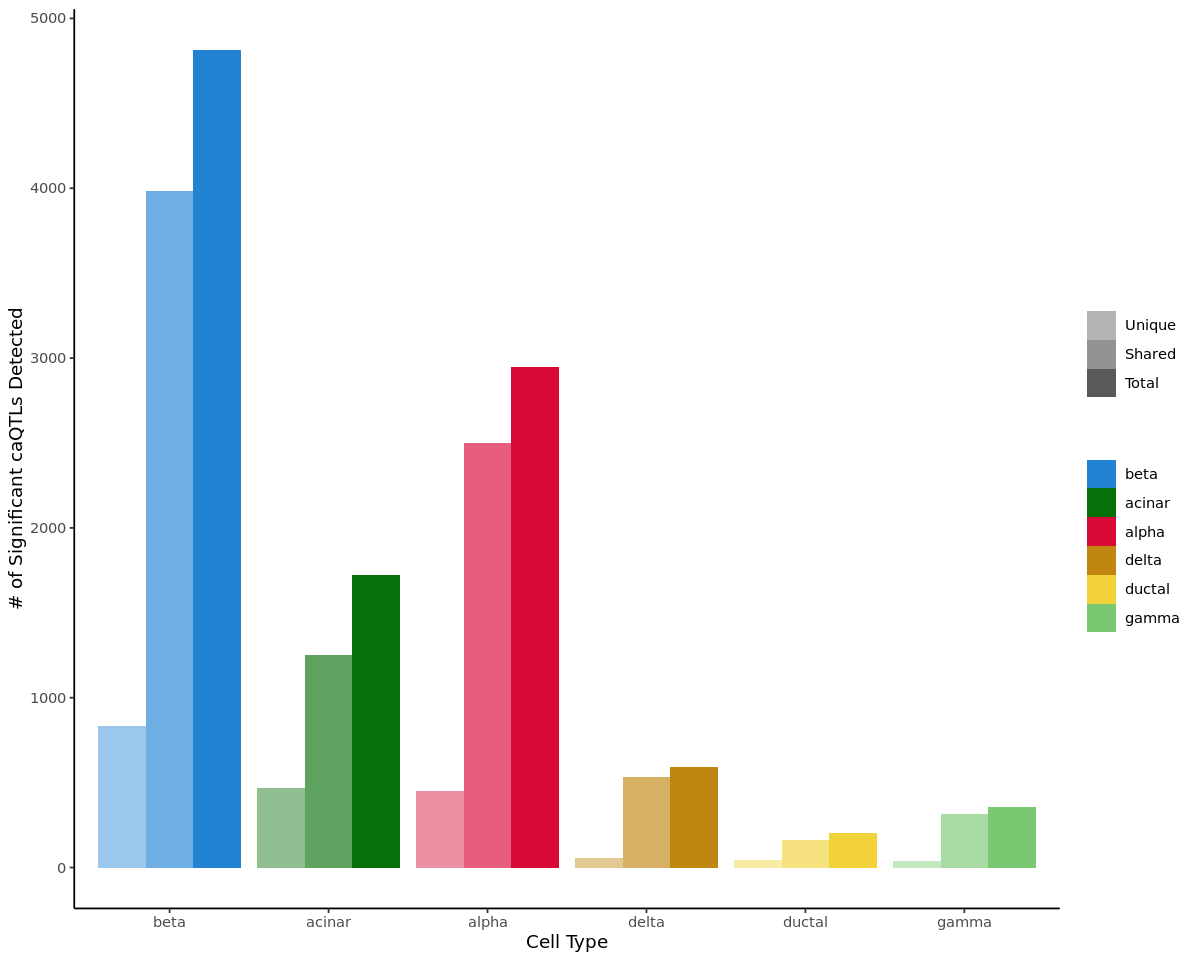

In [154]:
pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft_2_Unique_Including_Bulk.pdf",
   width=10, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(filter(summary_sig_QTLs_to_graph_no_bulk, Type %in% c('Unique','Shared','Total')), 
             aes(x=celltype, y=Value, fill=celltype, alpha=Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#077109', 'alpha'='#d90936', 'beta'='#2183d2',
                 'delta'='#c08610', 'ductal'='#f1d23a', 'gamma'='#7ac972')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    scale_alpha_manual(values=c(0.45, 0.65, 1)) +
    labs(fill = "", alpha="")
p1

dev.off()

p1

png 
  2

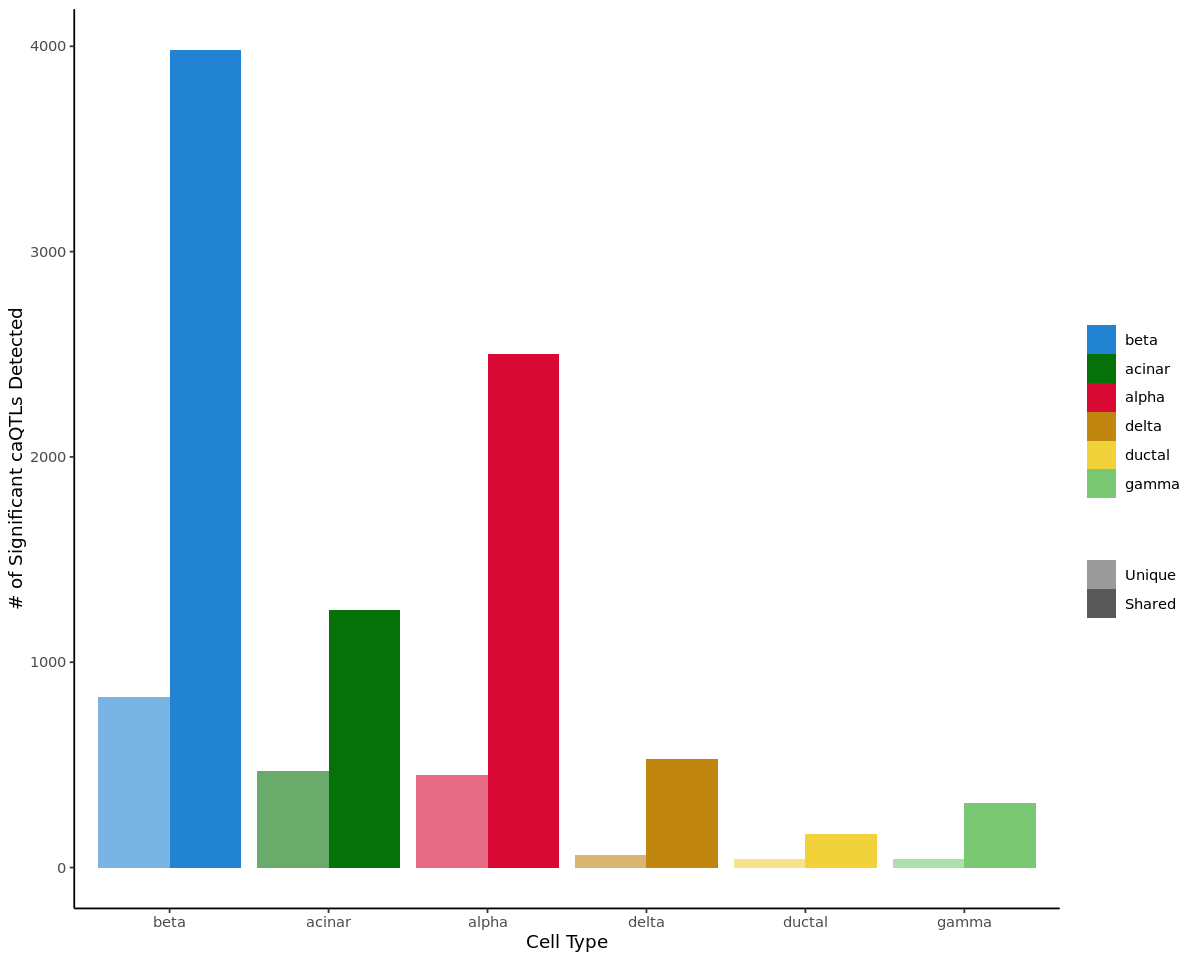

In [155]:
pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft_2_Unique_Including_Bulk_No_Tot.pdf",
   width=10, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(filter(summary_sig_QTLs_to_graph_no_bulk, Type %in% c('Unique','Shared')), 
             aes(x=celltype, y=Value, fill=celltype, alpha=Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#077109', 'alpha'='#d90936', 'beta'='#2183d2',
                 'delta'='#c08610', 'ductal'='#f1d23a', 'gamma'='#7ac972')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    scale_alpha_manual(values=c(0.6, 1)) +
    labs(fill = "", alpha="")
p1

dev.off()

p1

png 
  2

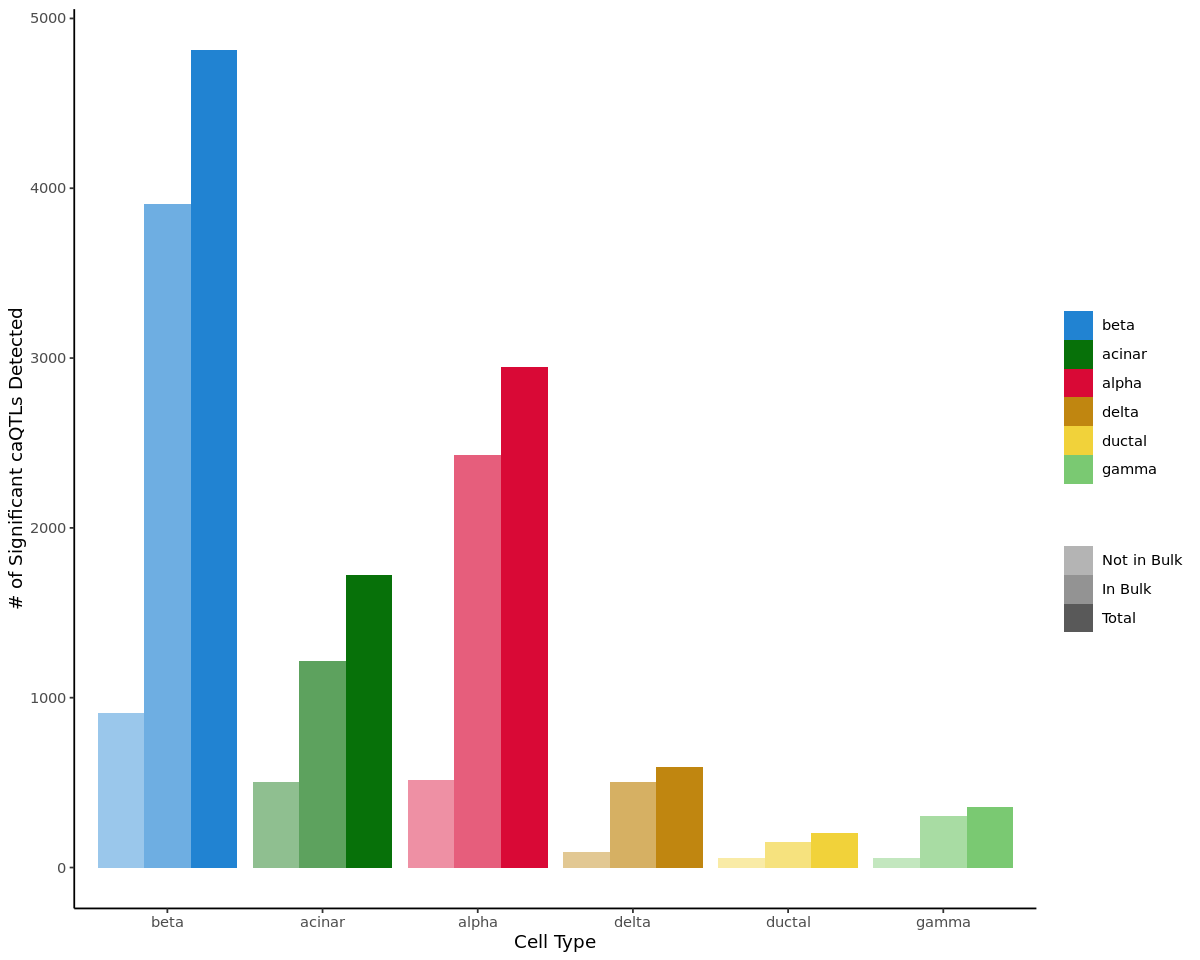

In [156]:
pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft_2_Unique_In_Bulk.pdf",
   width=10, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(filter(summary_sig_QTLs_to_graph_no_bulk, Type %in% c('In_Bulk','Not_In_Bulk','Total')), 
             aes(x=celltype, y=Value, fill=celltype, alpha=Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#077109', 'alpha'='#d90936', 'beta'='#2183d2',
                 'delta'='#c08610', 'ductal'='#f1d23a', 'gamma'='#7ac972')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    scale_alpha_manual(values=c(0.45, 0.65, 1), labels=c("Not in Bulk", "In Bulk", "Total")) +
    labs(fill = "", alpha="")
p1

dev.off()

p1

png 
  2

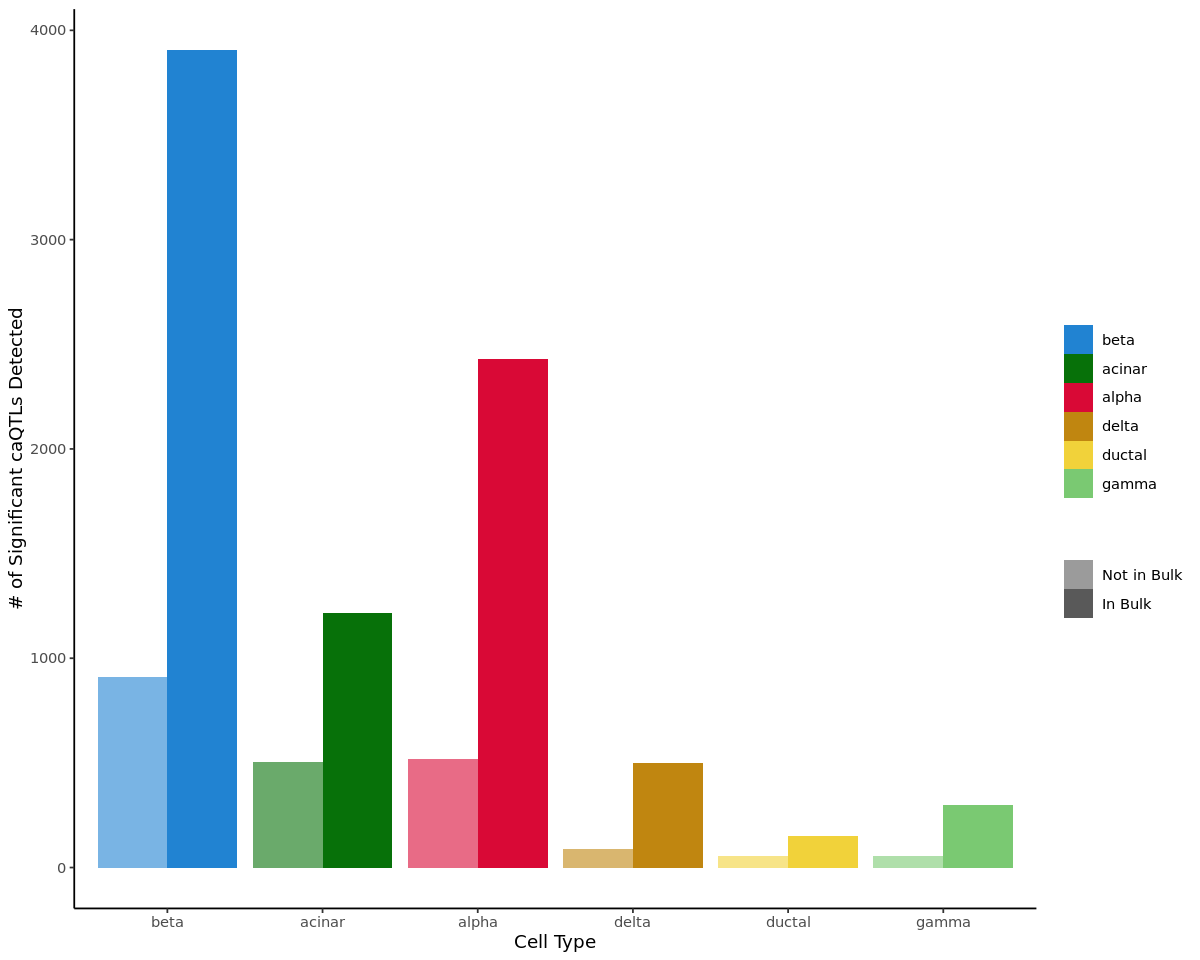

In [157]:
pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft_2_Unique_In_Bulk_No_Tot.pdf",
   width=10, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(filter(summary_sig_QTLs_to_graph_no_bulk, Type %in% c('In_Bulk','Not_In_Bulk')), 
             aes(x=celltype, y=Value, fill=celltype, alpha=Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#077109', 'alpha'='#d90936', 'beta'='#2183d2',
                 'delta'='#c08610', 'ductal'='#f1d23a', 'gamma'='#7ac972')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    scale_alpha_manual(values=c(0.6, 1), labels=c("Not in Bulk", "In Bulk")) +
    labs(fill = "", alpha="")
p1

dev.off()

p1

png 
  2

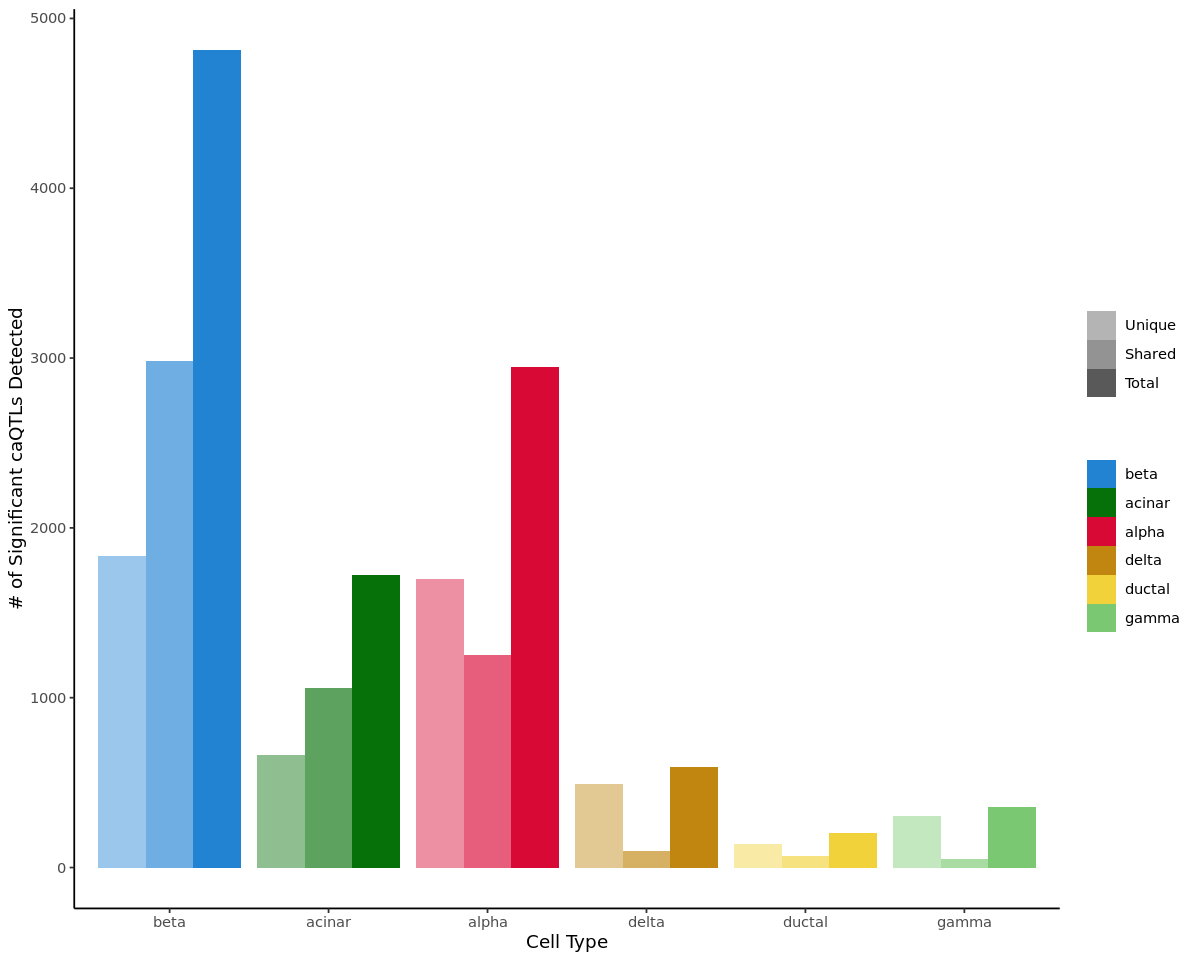

In [158]:
pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft_2_Unique_No_Bulk.pdf",
   width=10, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(filter(summary_sig_QTLs_to_graph_no_bulk, Type %in% c('Unique_Excluding_Bulk','Shared_Excluding_Bulk','Total')), 
             aes(x=celltype, y=Value, fill=celltype, alpha=Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#077109', 'alpha'='#d90936', 'beta'='#2183d2',
                 'delta'='#c08610', 'ductal'='#f1d23a', 'gamma'='#7ac972')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    scale_alpha_manual(values=c(0.45, 0.65, 1), labels=c("Unique", "Shared", "Total")) +
    labs(fill = "", alpha="")
p1

dev.off()

p1

png 
  2

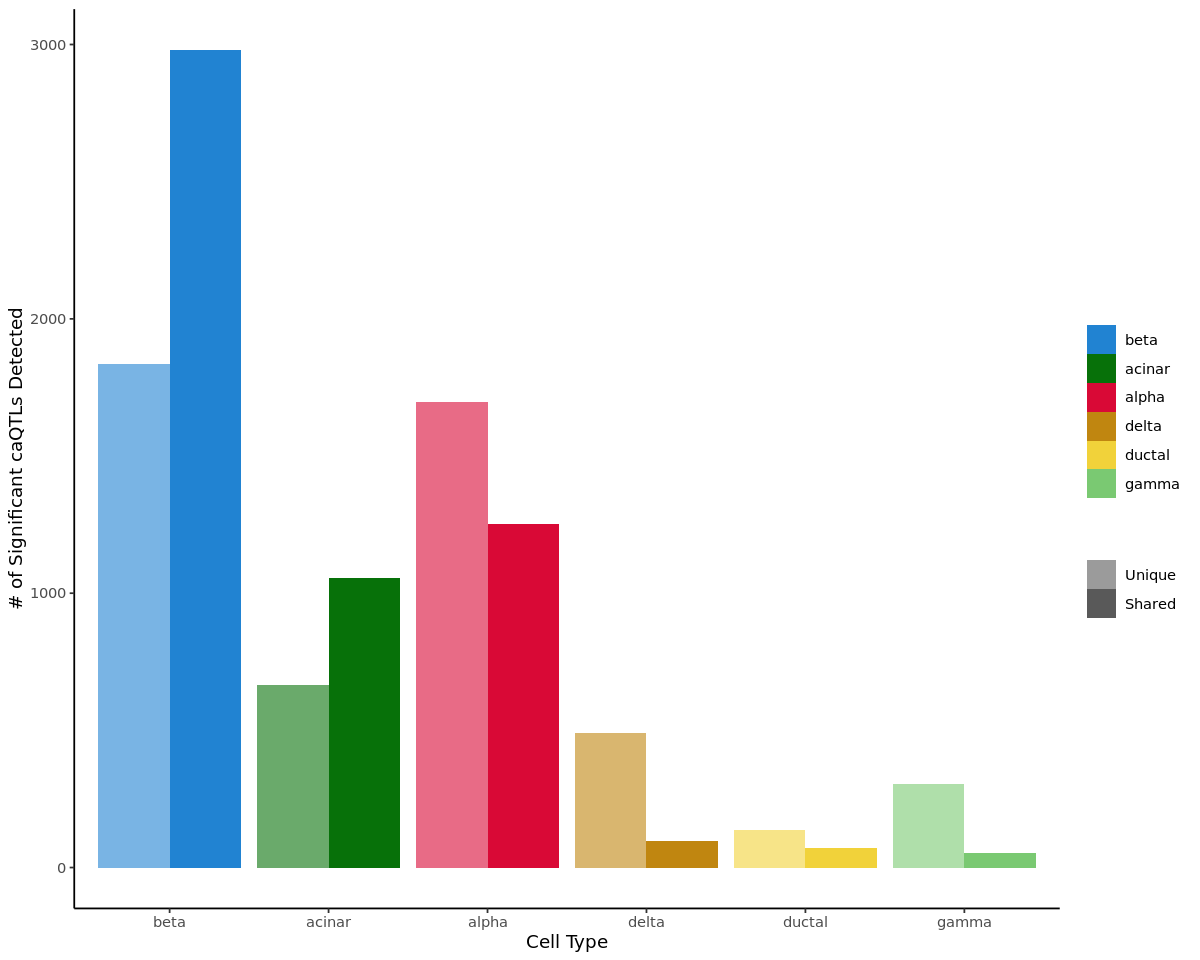

In [159]:
pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft_2_Unique_No_Bulk_No_Tot.pdf",
   width=10, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(filter(summary_sig_QTLs_to_graph_no_bulk, Type %in% c('Unique_Excluding_Bulk','Shared_Excluding_Bulk')), 
             aes(x=celltype, y=Value, fill=celltype, alpha=Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#077109', 'alpha'='#d90936', 'beta'='#2183d2',
                 'delta'='#c08610', 'ductal'='#f1d23a', 'gamma'='#7ac972')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    scale_alpha_manual(values=c(0.6, 1), labels=c("Unique", "Shared")) +
    labs(fill = "", alpha="")
p1

dev.off()

p1

png 
  2

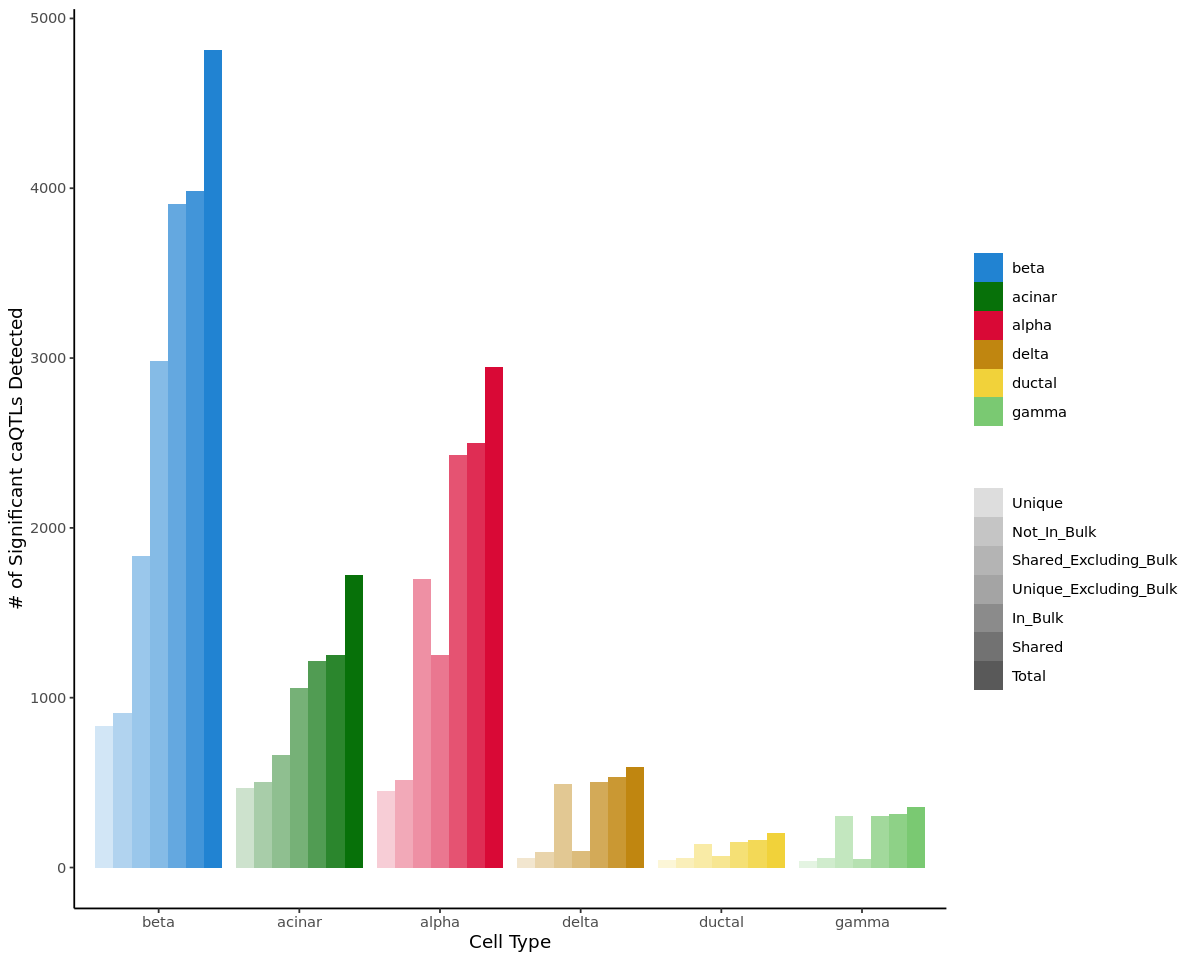

In [160]:
pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft_2_Unique_All.pdf",
   width=10, height=8)

#library(ggplot2)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(summary_sig_QTLs_to_graph_no_bulk, 
             aes(x=celltype, y=Value, fill=celltype, alpha=Type)) + 
geom_col(position=position_dodge(),size=0) + theme_classic() +
    scale_fill_manual(values=c('acinar'='#077109', 'alpha'='#d90936', 'beta'='#2183d2',
                 'delta'='#c08610', 'ductal'='#f1d23a', 'gamma'='#7ac972')) +
    theme(panel.background = element_blank()) +
    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
    scale_alpha_manual(values=c(0.2, 0.35, 0.45, 0.55, 0.7, 0.85, 1)) +
    labs(fill = "", alpha="")
p1

dev.off()

p1

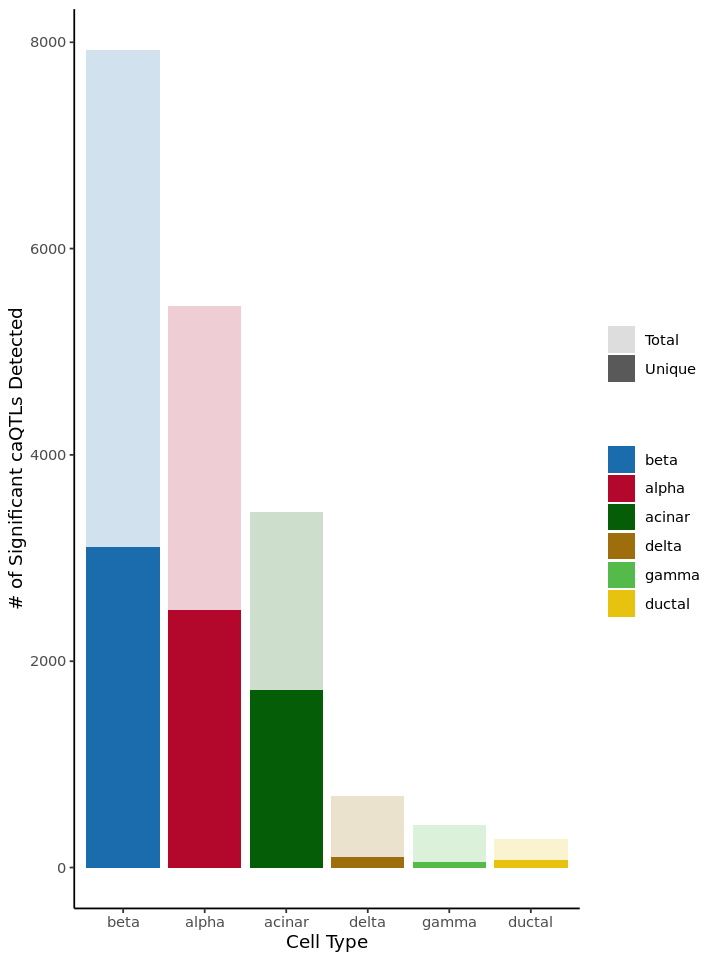

In [143]:
##pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft.svg",
##   width=6, height=8)
#
#options(repr.plot.width=6, repr.plot.height=8)
#p1 <- ggplot(QTL_Counts, aes(cell, Freq, fill = cell, alpha=Type)) + geom_col() + theme_classic() +
#    scale_fill_manual(values=c('acinar'='#065d07', 'alpha'='#b3072c', 'beta'='#1b6cac',
#                 'delta'='#9e6e0d', 'ductal'='#e7c30f', 'gamma'='#54ba4a')) +
#    theme(panel.background = element_blank()) +
#    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
#    scale_alpha_manual(values=c(0.2, 1)) +
#    labs(fill = "", alpha="")
#p1
#
##dev.off()
#
##p1

png 
  2

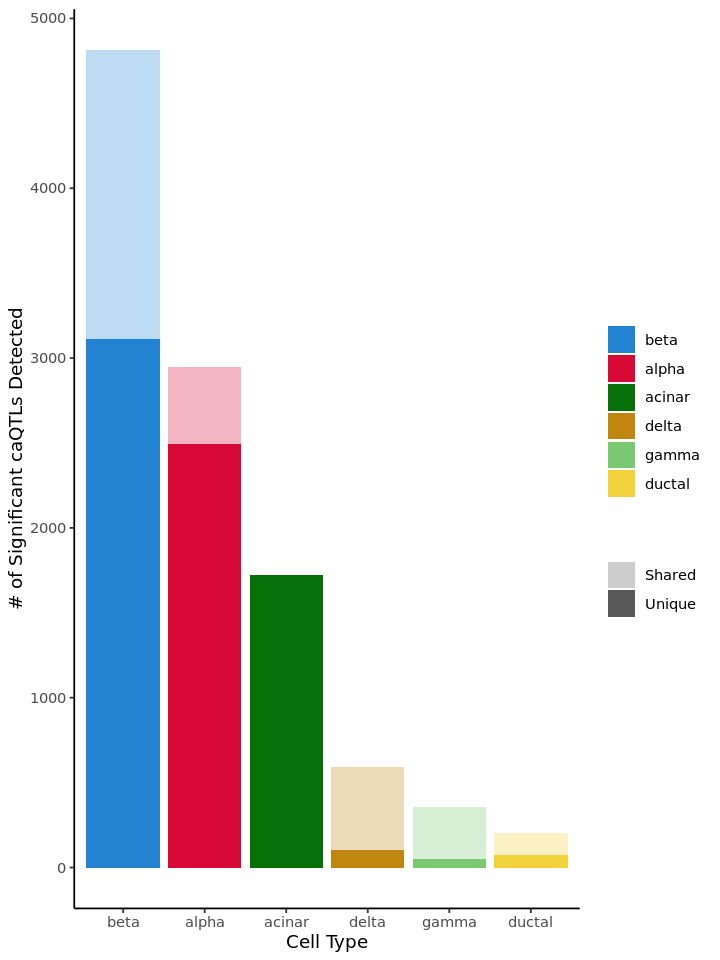

In [160]:
#pdf("/path/to/caQTL/stuff/figures/230615_WE_QTLs_Per_Celltype_Draft_3.pdf",
#   width=6, height=8)
#
#options(repr.plot.width=6, repr.plot.height=8)
#p1 <- ggplot(QTL_Counts, aes(cell, Freq, fill = cell, alpha=Type)) + geom_col() + theme_classic() +
#    scale_fill_manual(values=c('acinar'='#077109', 'alpha'='#d90936', 'beta'='#2183d2',
#                 'delta'='#c08610', 'ductal'='#f1d23a', 'gamma'='#7ac972')) +
#    theme(panel.background = element_blank()) +
#    xlab("Cell Type") + ylab("# of Significant caQTLs Detected") +
#    scale_alpha_manual(values=c(0.3, 1)) +
#    labs(fill = "", alpha="")
#p1
#
#dev.off()
#
#p1